In [1]:
import glob
import pandas as pd
import pylab as pl
%pylab inline
from scipy import signal

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Loading photos taken with shutter frequency 120, 119.75, 119, 100, 50 and 10 Hz; and camera frequency of 4 and 3.5hz 
#Special case for 119.75, because we saved the images as "11975"

shutter = [120, 119.75, 119, 100, 50, 10]

photo_files4 = {}
photo_files35 = {}

for i in shutter:
    if i == 119.75:
        path4 = '/scratch/share/fbianco/LEDtest/s%shz_c4hz*.raw' % 11975
        path35 = '/scratch/share/fbianco/LEDtest/s%shz_c35hz*.raw' % 11975
    else:
        path4 = '/scratch/share/fbianco/LEDtest/s%shz_c4hz*.raw' % i
        path35 = '/scratch/share/fbianco/LEDtest/s%shz_c35hz*.raw' % i
    photo_files4[str(i)] = glob.glob(path4)
    photo_files35[str(i)] = glob.glob(path35)

In [3]:
#Converting series into Numpy arrays

photo_arrays4 = {}
photo_arrays35 = {}

for key, value in photo_files4.iteritems():
    photo_arrays4[key] = np.array(value)[np.argsort(value)] 
    
for key, value in photo_files35.iteritems():
    photo_arrays35[key] = np.array(value)[np.argsort(value)] 

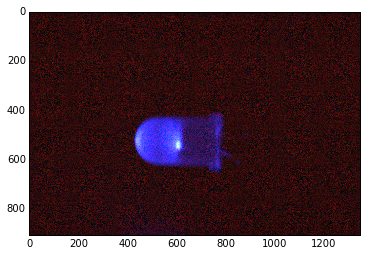

In [4]:
#Testing several configurations to find the right nrow/ncol

nrow = 908
ncol = 1344
nband = 3

pl.figure()
pl.imshow(np.fromfile(photo_arrays35['119.75'][250], dtype=np.uint8).reshape(nrow, ncol, nband))
pl.show()

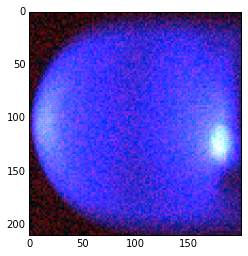

In [5]:
#Testing image size so as to crop "non-lamp" parts 

pl.imshow(np.fromfile(photo_arrays35['119.75'][250],dtype=np.uint8).reshape(nrow,ncol,nband)[420:630,425:625])
pl.show()

In [6]:
#Resizing all series
#Excluding 119/3.5 Hz setting as it is crashing (possibly because of missing photos)

photo_resized4 = {}
photo_resized35 = {}

for key, value in photo_arrays4.iteritems():
    photo_resized4[key] = np.zeros(len(value))

for key, value in photo_arrays35.iteritems():
    if key != '119':
        photo_resized35[key] = np.zeros(len(value))

for r in photo_resized4:
    for i,f in enumerate(photo_arrays4[r]):
        photo_resized4[r][i] = sum(np.fromfile(f,dtype=np.uint8).reshape(nrow,ncol,nband)[420:630,425:625])        
        
for r in photo_resized35:
    for i,f in enumerate(photo_arrays35[r]):
        photo_resized35[r][i] = sum(np.fromfile(f,dtype=np.uint8).reshape(nrow,ncol,nband)[420:630,425:625])

## Flux vs Image Number

In [7]:
#Creating dictionaries for flux
#Normalizing flux by (flux-mean)/std

flux4 = {}
flux35 = {}

for key, value in photo_resized4.iteritems():
    flux4[key] = (value-value.mean())/value.std()

for key, value in photo_resized35.iteritems():
    flux35[key] = (value-value.mean())/value.std()
    
#Further normalization. Keeping all values positive and between 0 and 2 (consistent with the simulated wave)

for key, value in flux4.iteritems():
    temp = value-np.min(value)
    flux4[key] = 2*(temp)/np.max(temp)
    
for key, value in flux35.iteritems():
    temp = value-np.min(value)
    flux35[key] = 2*(temp)/np.max(temp)

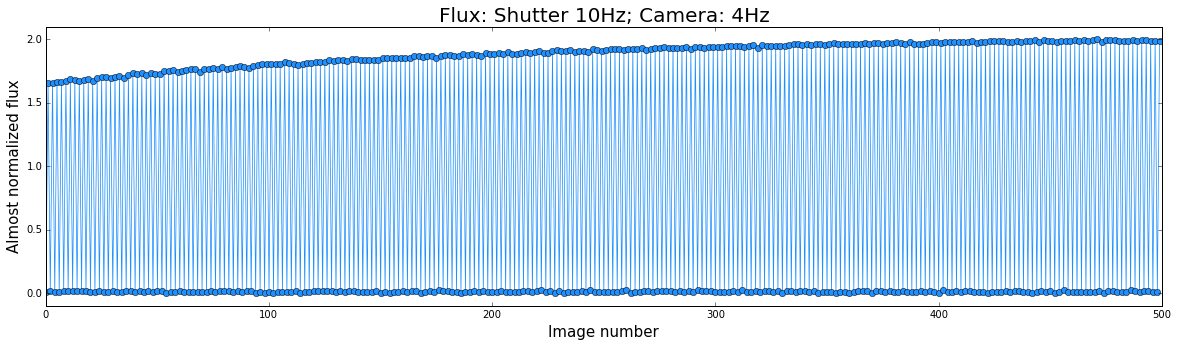

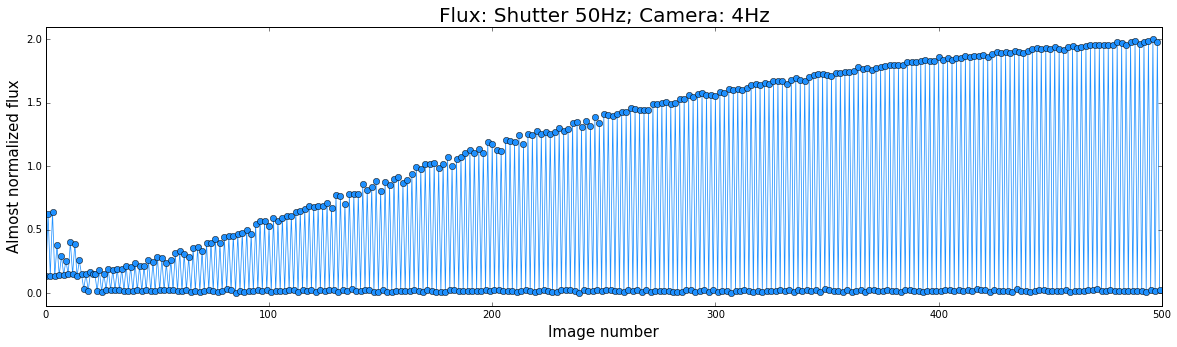

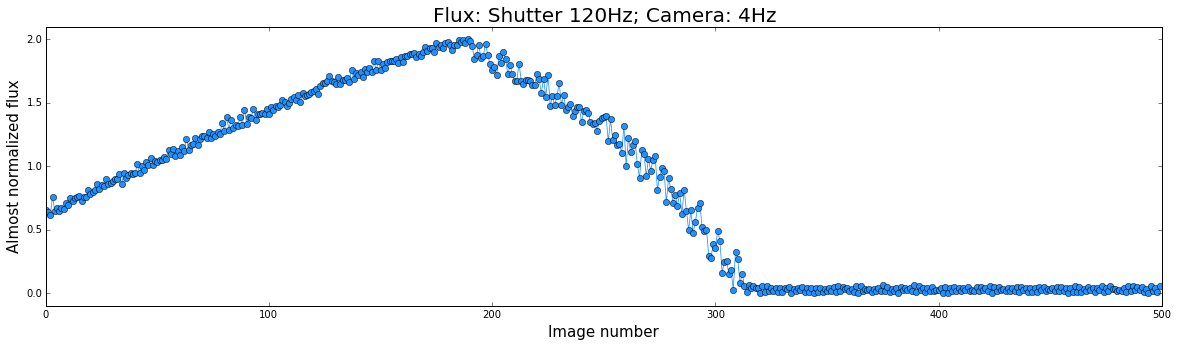

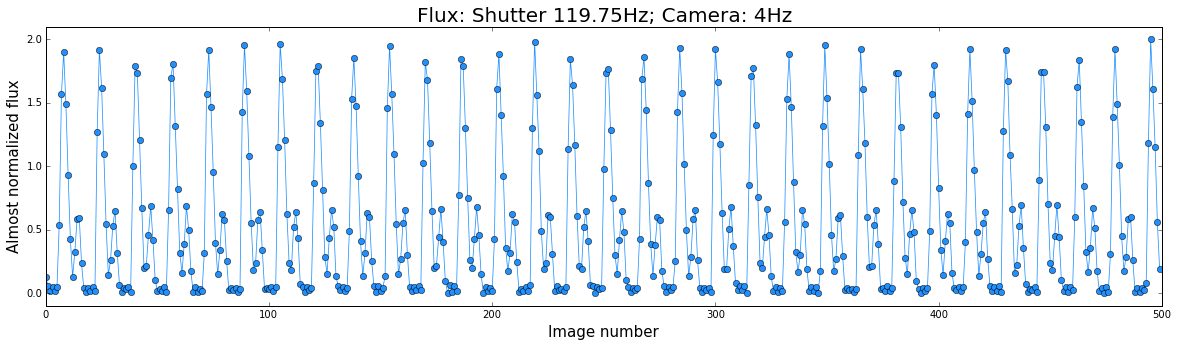

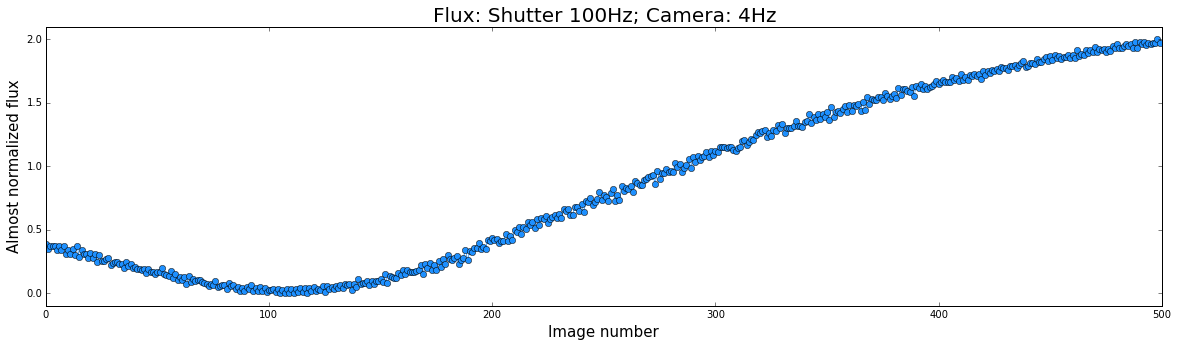

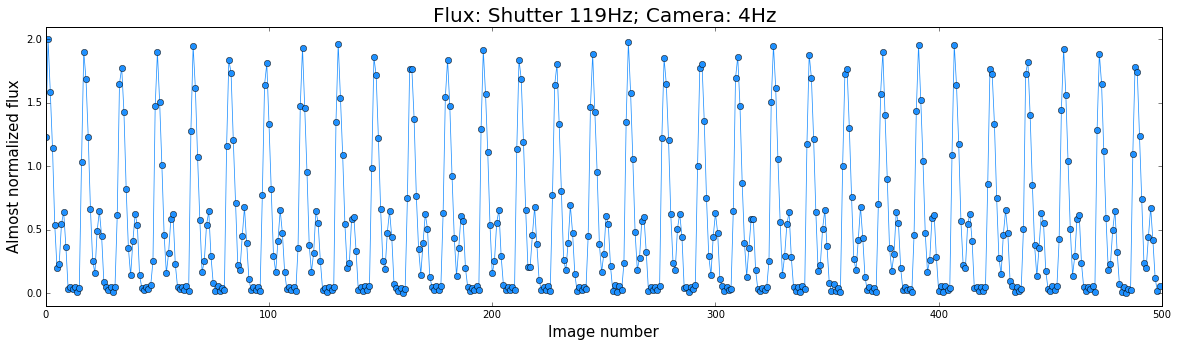

In [8]:
#Plotting the flux (Camera: 4hz)

for key, value in flux4.iteritems():
    pl.figure(figsize=(20,5))
    pl.plot(value, '-', color='dodgerblue', linewidth=0.75)
    pl.plot(value, 'o', color='dodgerblue')
    pl.xlabel("Image number", fontsize=15)
    pl.ylabel("Almost normalized flux", fontsize=15)
    pl.title('Flux: Shutter '+key+'Hz; Camera: 4Hz', fontsize=20)
    pl.ylim(-.1,2.1)
    pl.show()

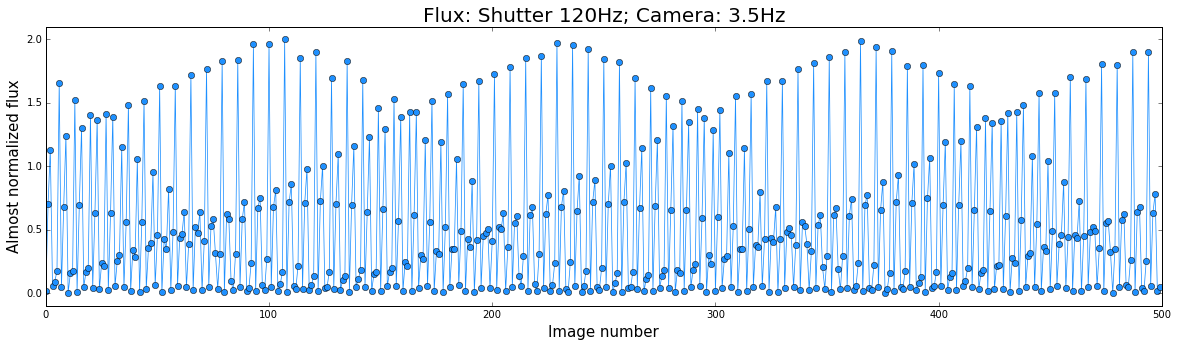

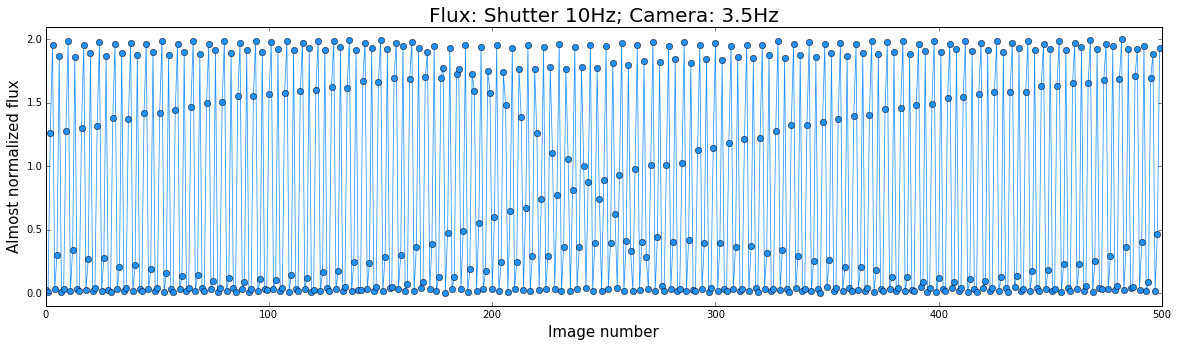

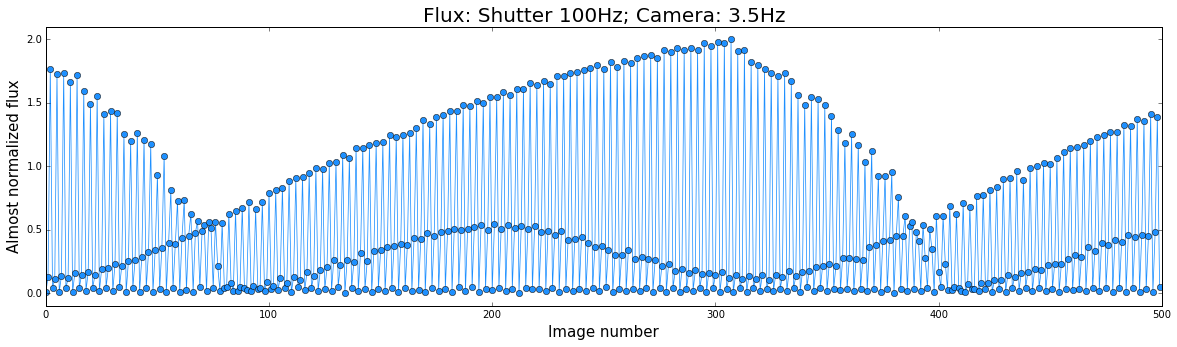

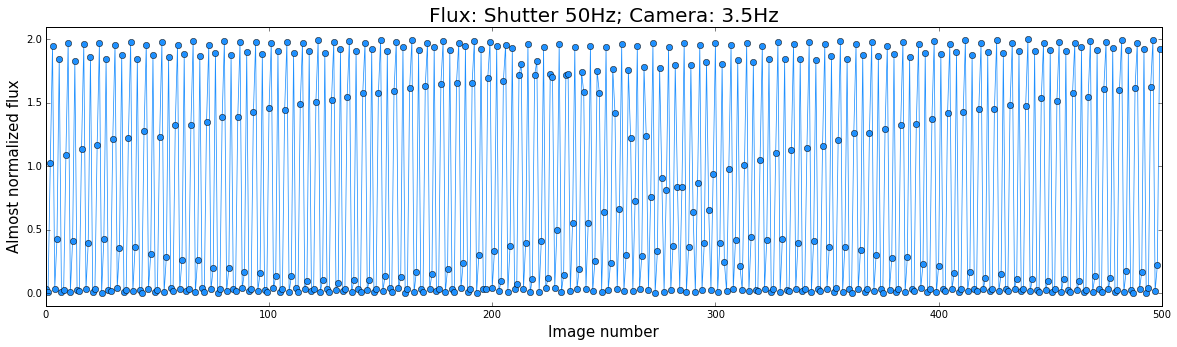

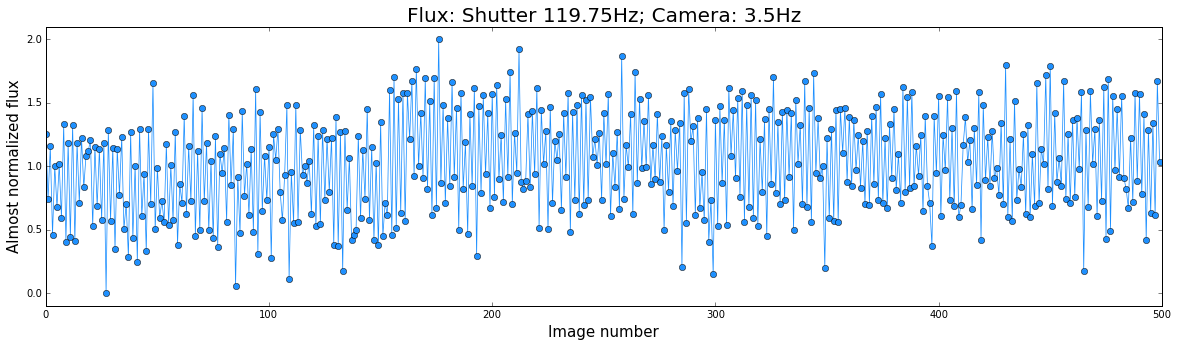

In [9]:
#Plotting the flux (Camera: 3.5hz)

for key, value in flux35.iteritems():
    pl.figure(figsize=(20,5))
    pl.plot(value, '-', color='dodgerblue', linewidth=0.75)
    pl.plot(value, 'o', color='dodgerblue')
    pl.xlabel("Image number", fontsize=15)
    pl.ylabel("Almost normalized flux", fontsize=15)
    pl.title('Flux: Shutter '+key+'Hz; Camera: 3.5Hz', fontsize=20)
    pl.ylim(-.1,2.1)
    pl.show()

## Flux vs Time

In [10]:
#Calculating the runtime

runtime4 = {}
runtime35 = {}

for key, value in photo_resized4.iteritems():
    runtime4[key] = np.linspace(0, len(value)/4, len(value), endpoint=True)

for key, value in photo_resized35.iteritems():
    runtime35[key] = np.linspace(0, len(value)/3.5, len(value), endpoint=True)

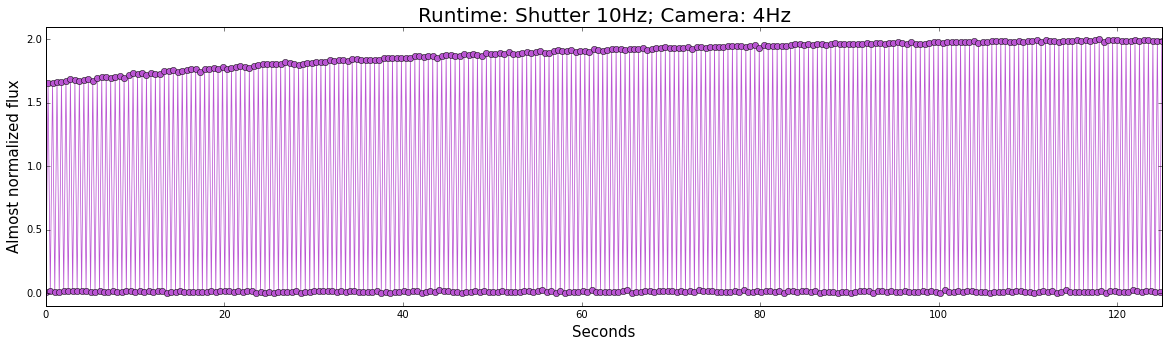

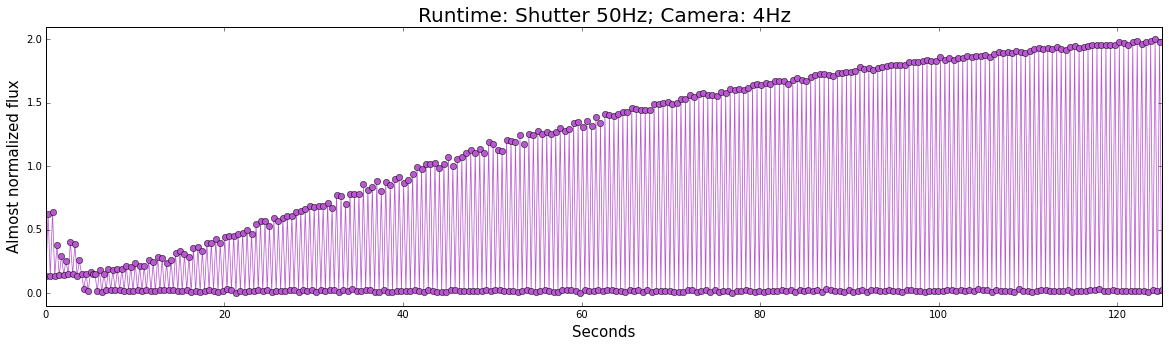

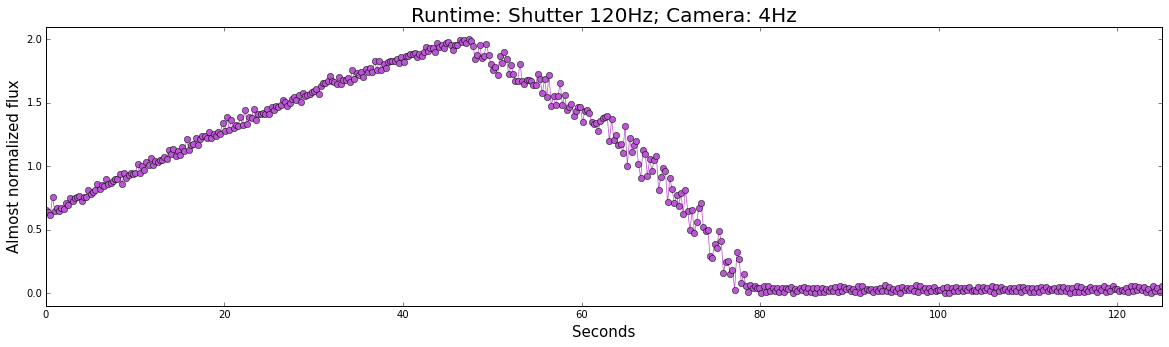

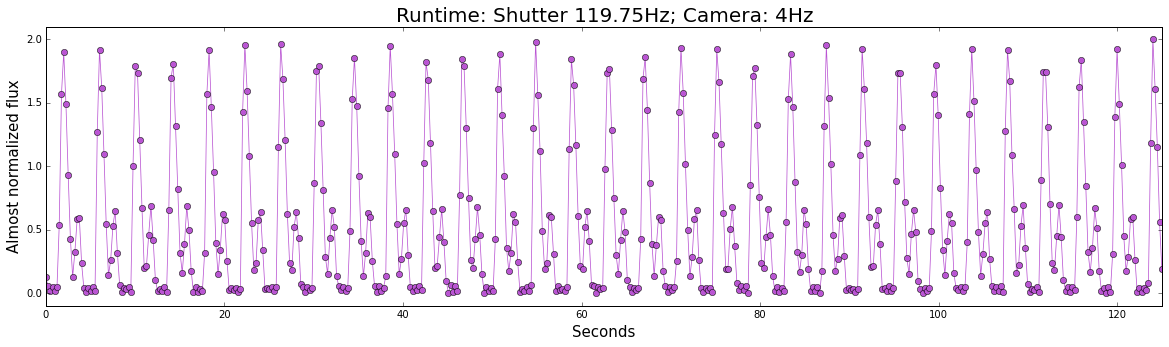

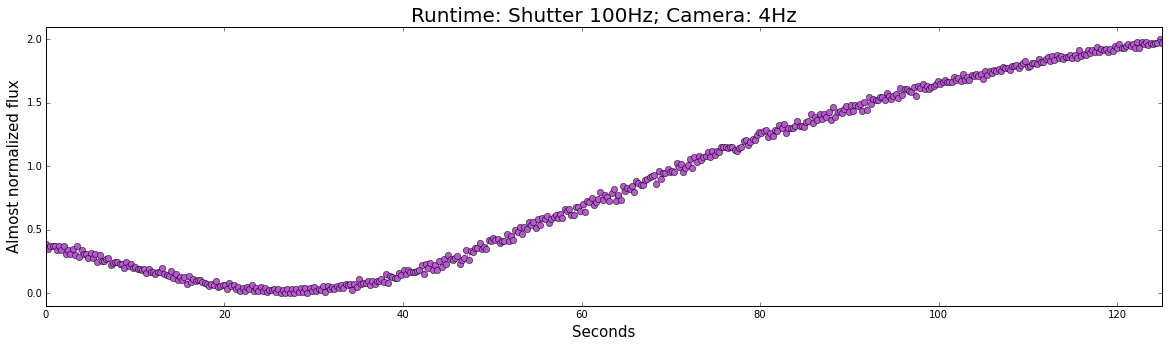

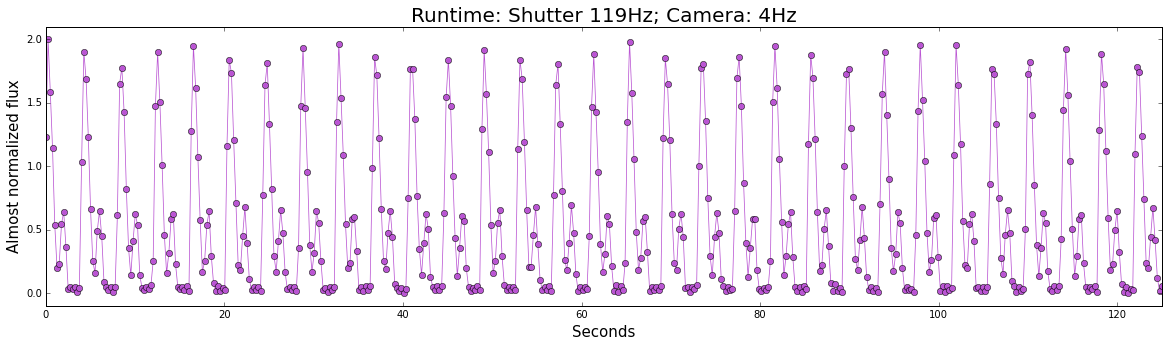

In [11]:
#Plotting the runtime (Camera: 4hz)

for key, value in runtime4.iteritems():
    pl.figure(figsize=(20,5))
    pl.plot(value, flux4[key], '-', color='mediumorchid', linewidth=0.75)
    pl.plot(value, flux4[key], 'o', color='mediumorchid')
    pl.xlabel("Seconds", fontsize=15)
    pl.ylabel("Almost normalized flux", fontsize=15)
    pl.title('Runtime: Shutter '+key+'Hz; Camera: 4Hz', fontsize=20)
    pl.xlim(0,125)
    pl.ylim(-.1,2.1)
    pl.show()    

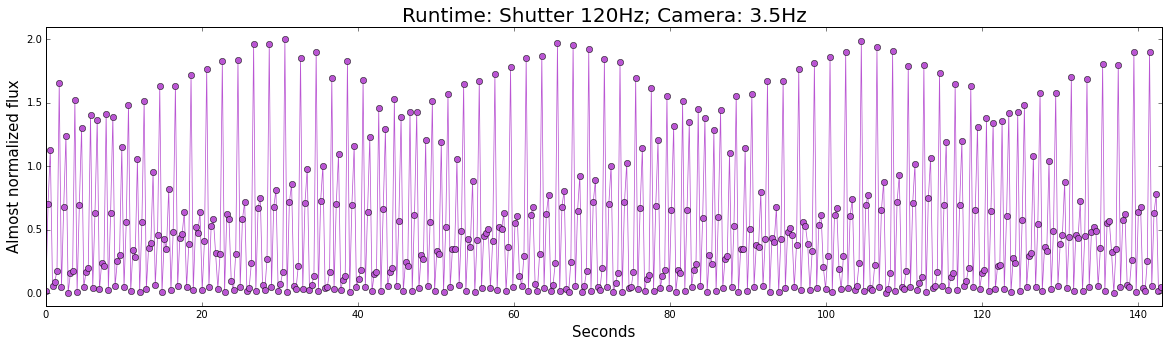

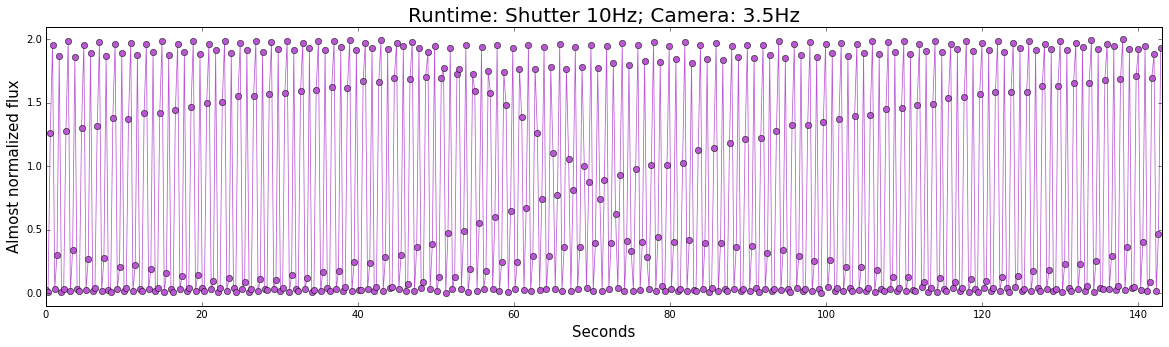

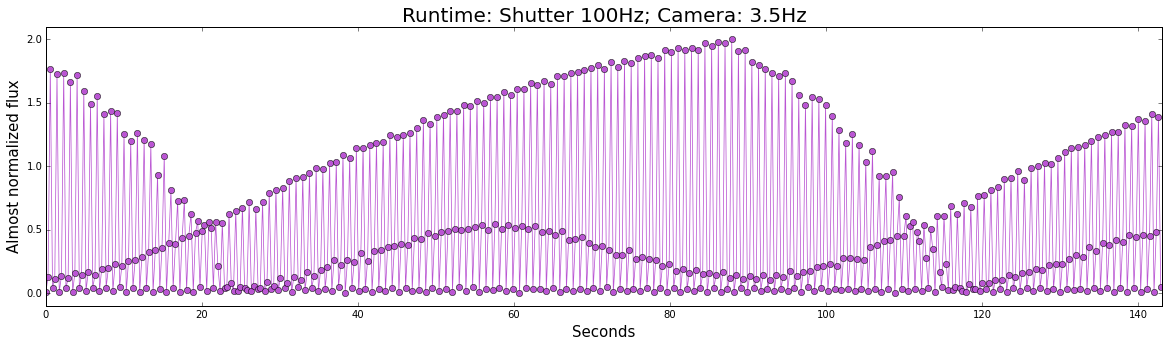

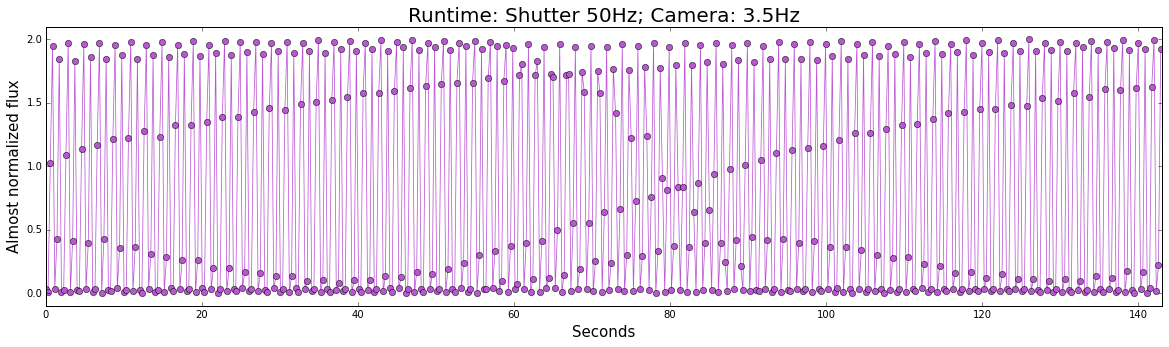

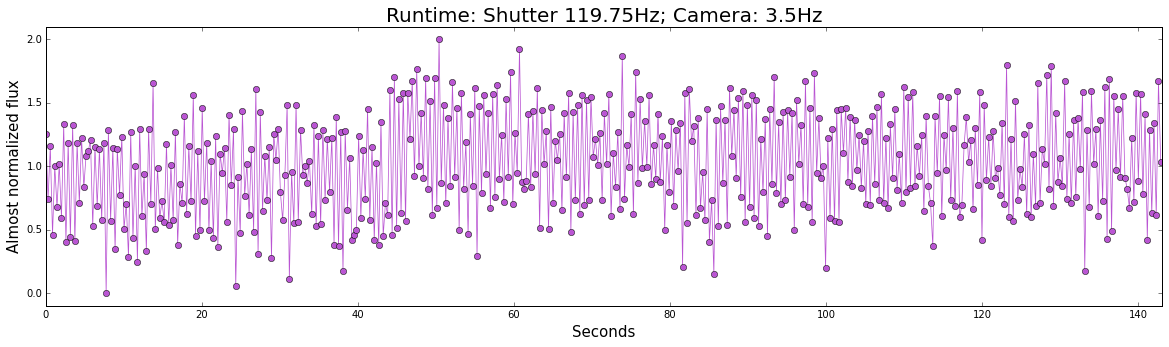

In [12]:
#Plotting the runtime (Camera: 3.5hz)

for key, value in runtime35.iteritems():
    pl.figure(figsize=(20,5))
    pl.plot(value, flux35[key], '-', color='mediumorchid', linewidth=0.75)
    pl.plot(value, flux35[key], 'o', color='mediumorchid')
    pl.xlabel("Seconds", fontsize=15)
    pl.ylabel("Almost normalized flux", fontsize=15)
    pl.title('Runtime: Shutter '+key+'Hz; Camera: 3.5Hz', fontsize=20)
    pl.xlim(0,143)
    pl.ylim(-.1,2.1)
    pl.show()    

## Simulated flux (sine wave)

In [13]:
#I'm trying to find the flux that would be expected given the camera/shutter settings
#I'm dividing the analysis into the 2 camera speeds
#At the highest camera speed (4hz), the 500 photos take 125 sec to be taken (1/(4)*500), and a photo is taken every 250ms
#At the lowest camera speed (3.5hz), the 500 photos take 143 sec to be taken (1/(3.5)*500), and a photo is taken every 286ms
#Using a time of 150,000ms


##FBB i think these should be floating point numbers
cam4 = np.zeros(150000)
cam4[np.arange(150000)%250 == 0] = 1
        
cam35 = np.zeros(150000)
cam35[np.arange(150000)%286 == 0] = 1

#FBB just checking
#pl.plot(cam35[245:295],'r-')
#pl.plot(cam4[245:255],'g-')

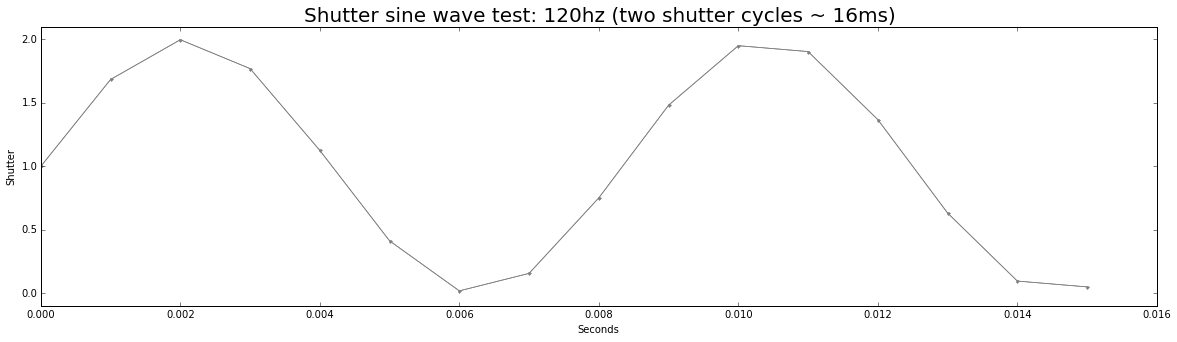

In [14]:
#I'm trying to simulate sine waves for the shutter

sine = {}
time = np.linspace(0, 150, 150*1000)

for i in shutter:
    sine[i] = np.sin(2*np.pi*time*i)+1

#Visualizing it for 10hz: 10 cycles in one sec; seems ok
#FBB setting up so we can easily visualize all other frequencies: you are rather undersampled at 120hz
hzhere =120
nsteps = 2*int(1000/hzhere)
plt.figure(figsize=(20,5))
pl.plot(time[:nsteps], sine[hzhere][:nsteps], '-', color='grey', linewidth = 0.75)
pl.plot(time[:nsteps], sine[hzhere][:nsteps], '.-', color='grey', linewidth = 0.75)

pl.title('Shutter sine wave test: %dhz (two shutter cycles ~ 16ms)'%hzhere, fontsize=20)
pl.xlabel('Seconds')
pl.ylabel('Shutter')
pl.ylim(-.1, 2.1);

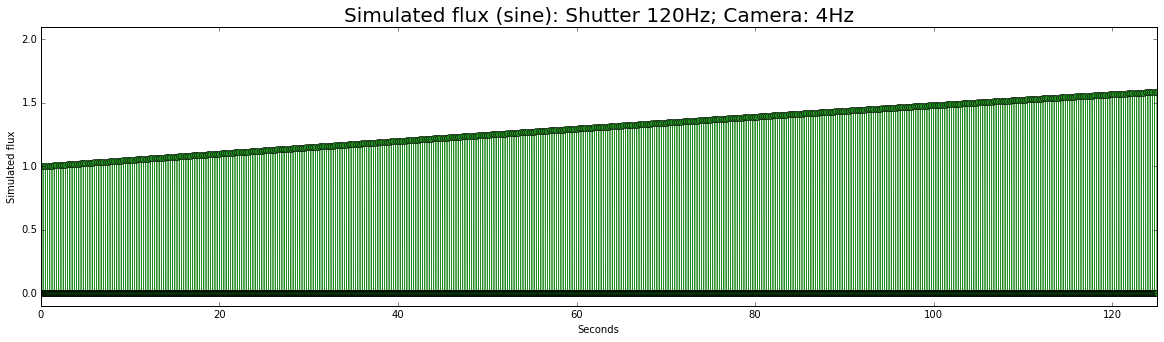

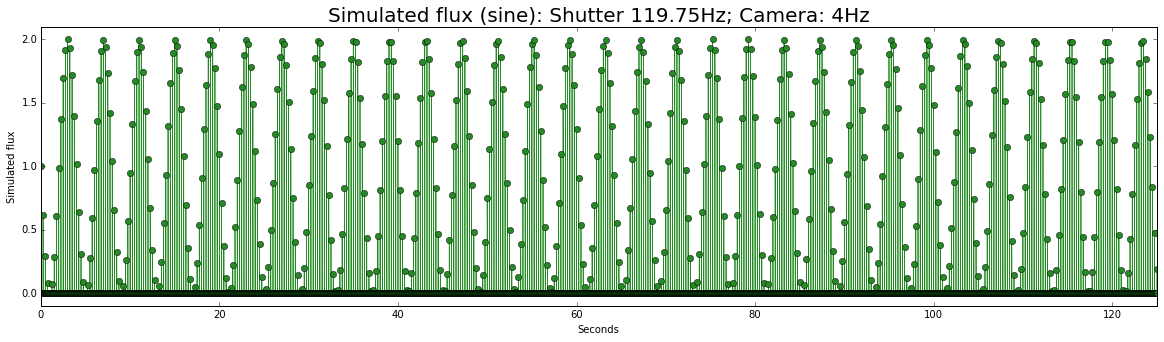

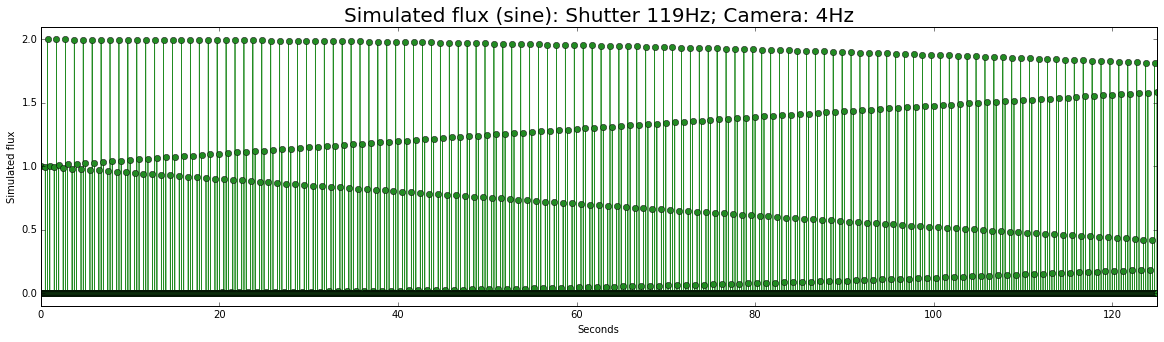

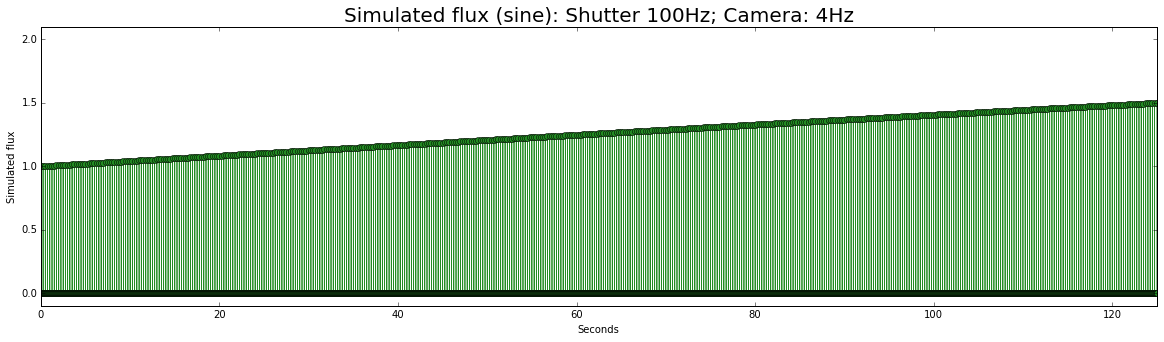

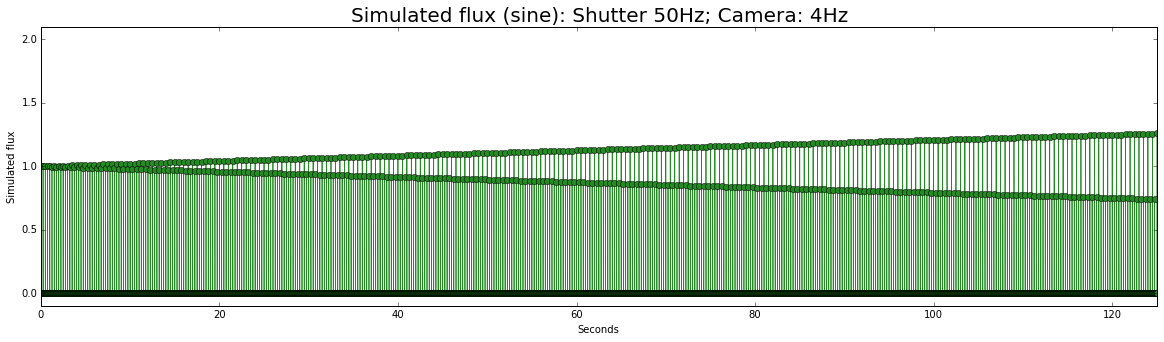

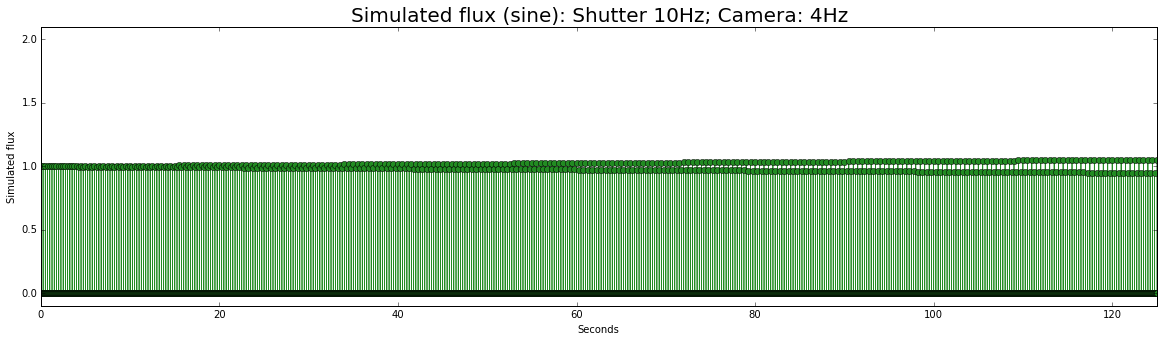

In [15]:
#Plotting the simulated fluxes for camera speed of 4hz
#This flux equals the points in which the camera "meets" the shutter wave

inter_sn4 = {}

for i in shutter:
    inter_sn4[str(i)] = (sine[i])*cam4
    pl.figure(figsize(20, 5))
    pl.plot(time, inter_sn4[str(i)], '-', color='forestgreen', linewidth = 0.75)
    pl.plot(time, inter_sn4[str(i)], 'o', color='forestgreen', linewidth = 0.75)
    pl.title('Simulated flux (sine): Shutter '+str(i)+'Hz; Camera: 4Hz', fontsize=20)
    pl.xlabel('Seconds')
    pl.ylabel('Simulated flux')
    pl.xlim(0,125)
    pl.ylim(-.1,2.1)
    pl.show()

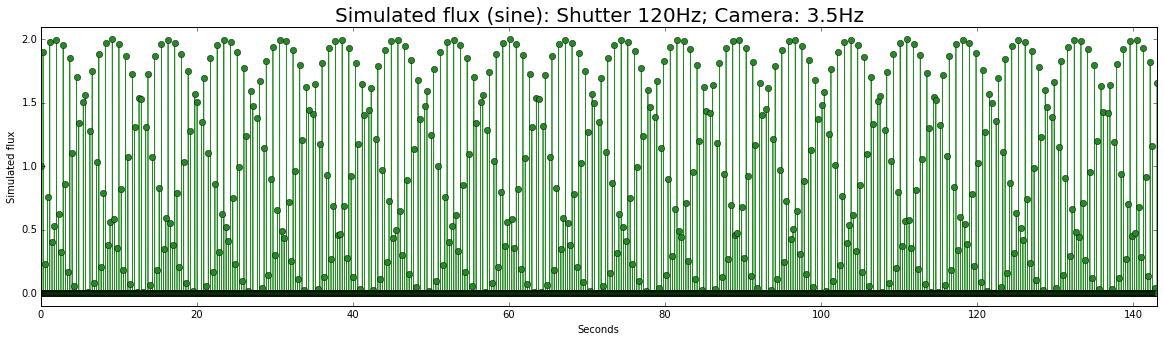

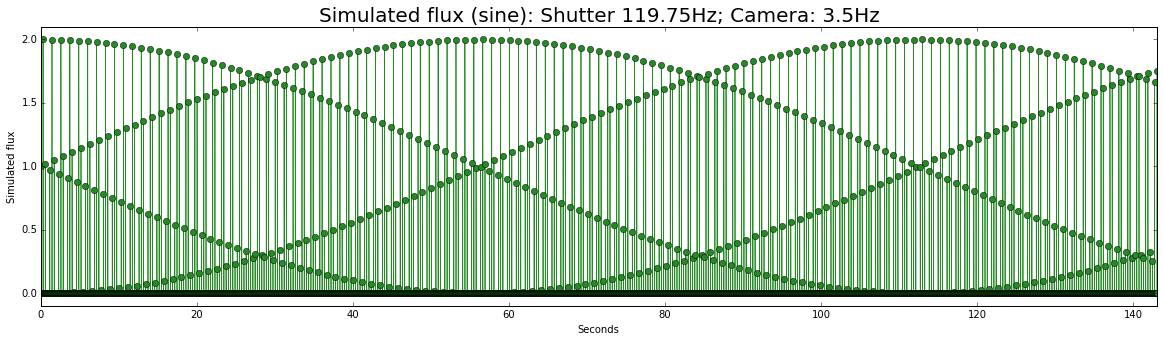

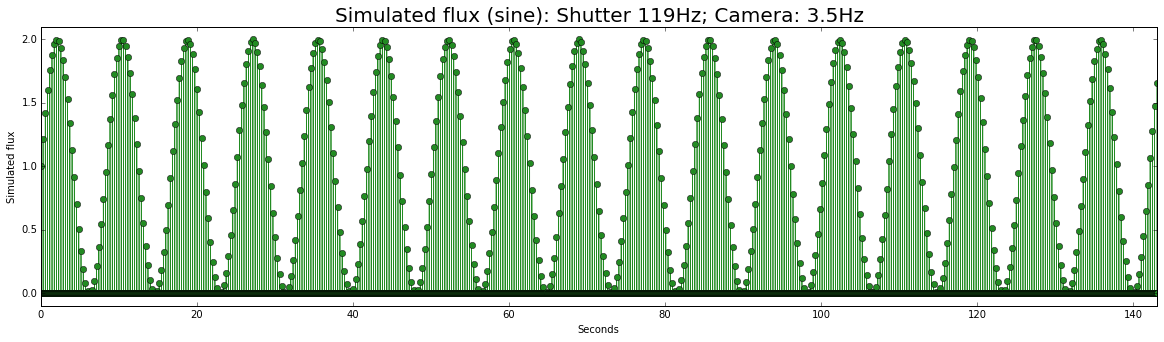

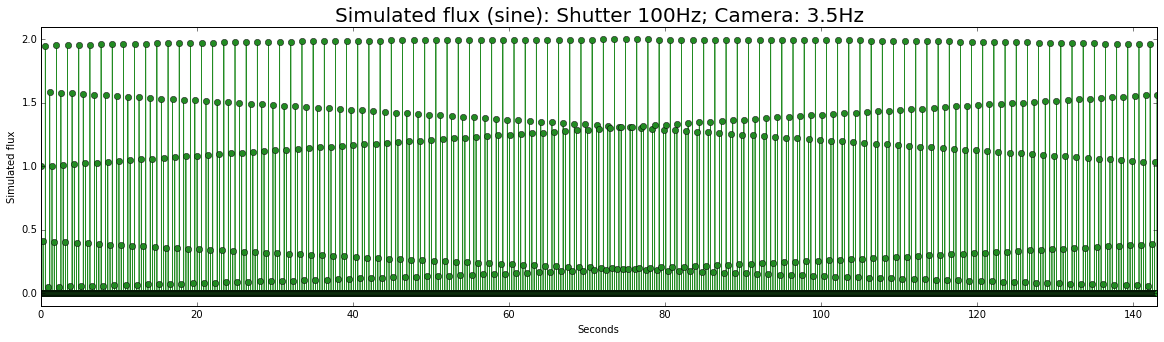

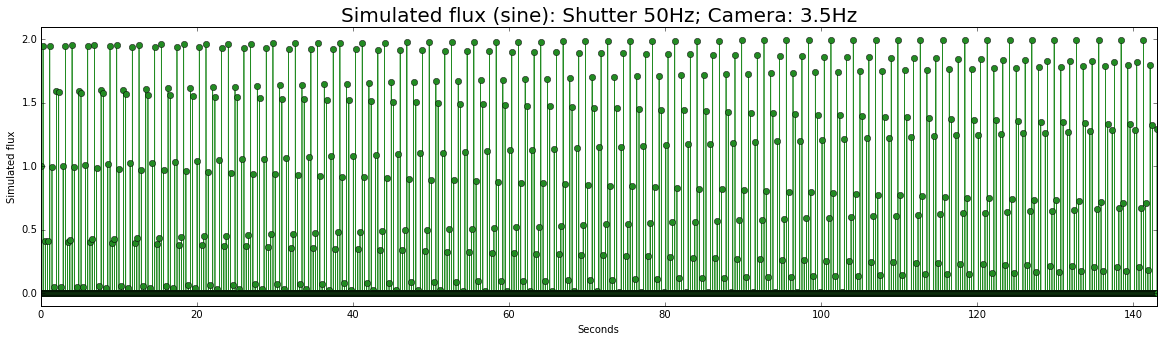

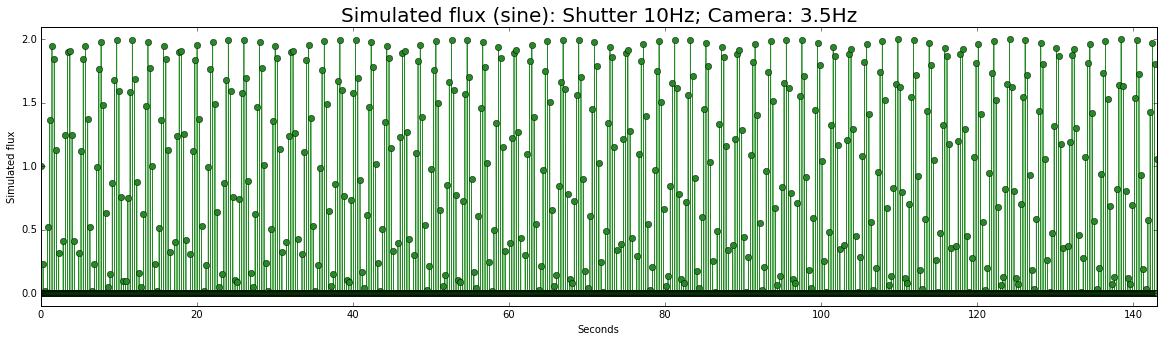

In [16]:
#Plotting the simulated fluxes for camera speed of 3.5hz
#This flux equals the points in which the camera "meets" the shutter wave

inter_sn35 = {}

for i in shutter:
    inter_sn35[str(i)] = (sine[i])*cam35
    pl.figure(figsize(20, 5))
    pl.plot(time, inter_sn35[str(i)], '-', color='forestgreen', linewidth = 0.75)
    pl.plot(time, inter_sn35[str(i)], 'o', color='forestgreen', linewidth = 0.75)
    pl.title('Simulated flux (sine): Shutter '+str(i)+'Hz; Camera: 3.5Hz', fontsize=20)
    pl.xlabel('Seconds')
    pl.ylabel('Simulated flux')
    pl.xlim(0,143)
    pl.ylim(-.1,2.1)
    pl.show()

## Simulated flux (square wave)

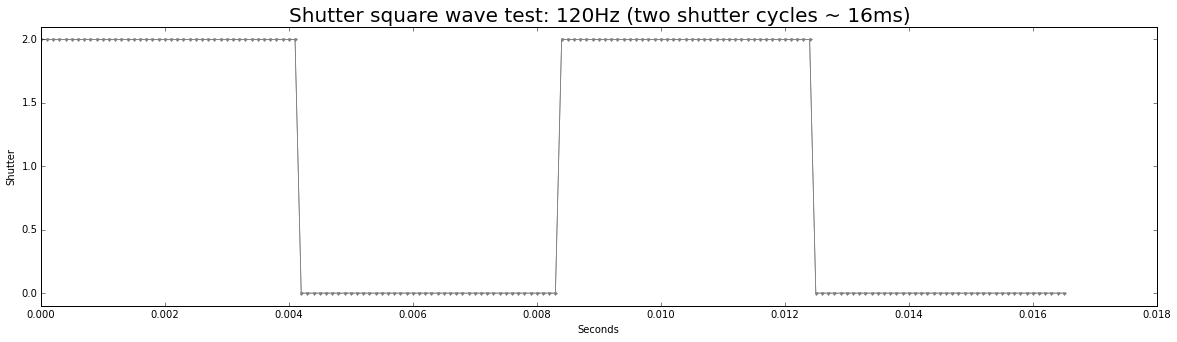

In [17]:
#I'm now trying to simulate square waves for the shutter

square = {}

#Folding the time series to reconstruct two shutter cycles
time2 = np.linspace(0, 150, 150*10000, endpoint=False)
for i in shutter:
    square[i] = signal.square(2*np.pi*time2*i)+1.0

hzhere =120
nsteps = 2*int(10000/hzhere)
pl.plot(time2[:nsteps], square[hzhere][:nsteps], '-', color='grey', linewidth = 0.75)
pl.plot(time2[:nsteps], square[hzhere][:nsteps], '.-', color='grey', linewidth = 0.75)

pl.title('Shutter square wave test: %dHz (two shutter cycles ~ 16ms)'%hzhere, fontsize=20)
pl.xlabel('Seconds')
pl.ylabel('Shutter')
pl.ylim(-.1, 2.1)
pl.show()

In [18]:
cam4_05ms = np.zeros(1500000)
cam35_05ms = np.zeros(1500000)

for i in range(10):
    cam4_05ms[i::10] += np.arange(150000)%250 == 0
    cam35_05ms[i::10] += np.arange(150000)%286 == 0

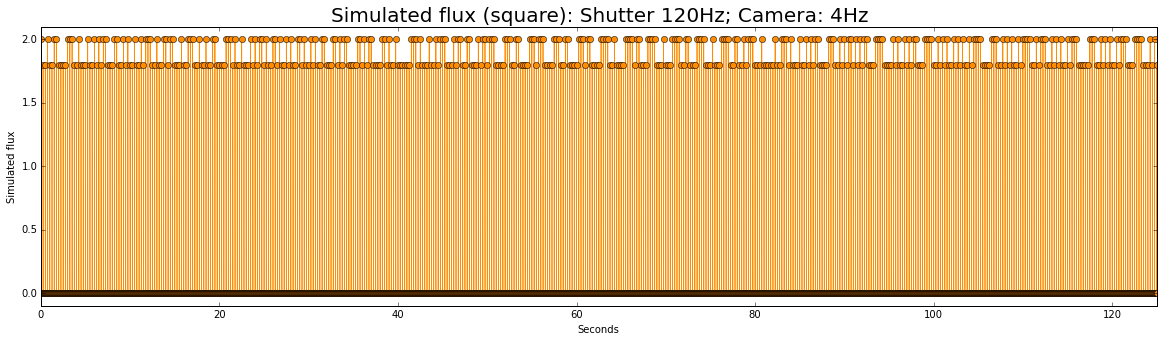

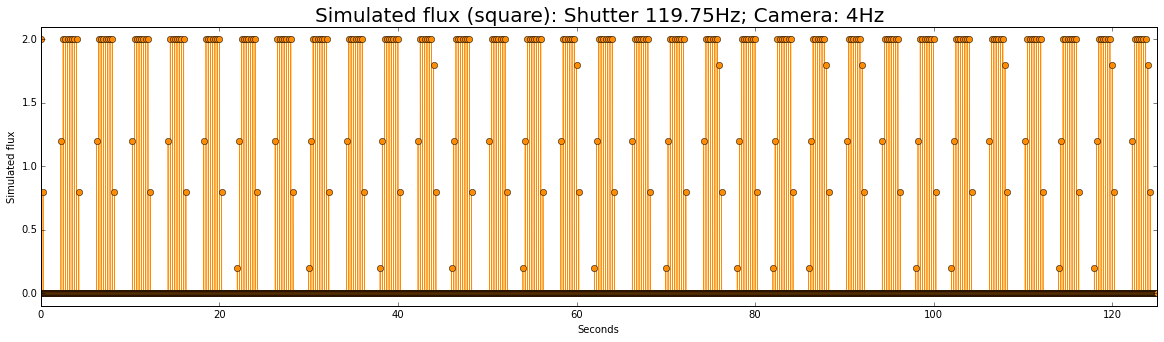

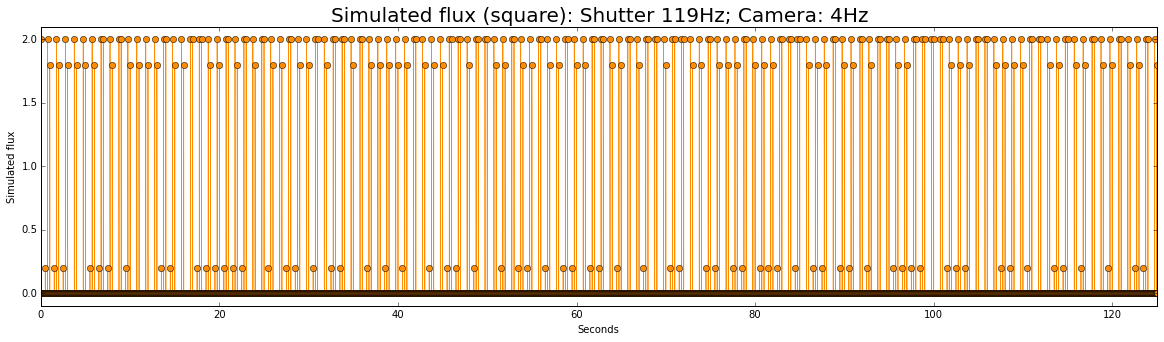

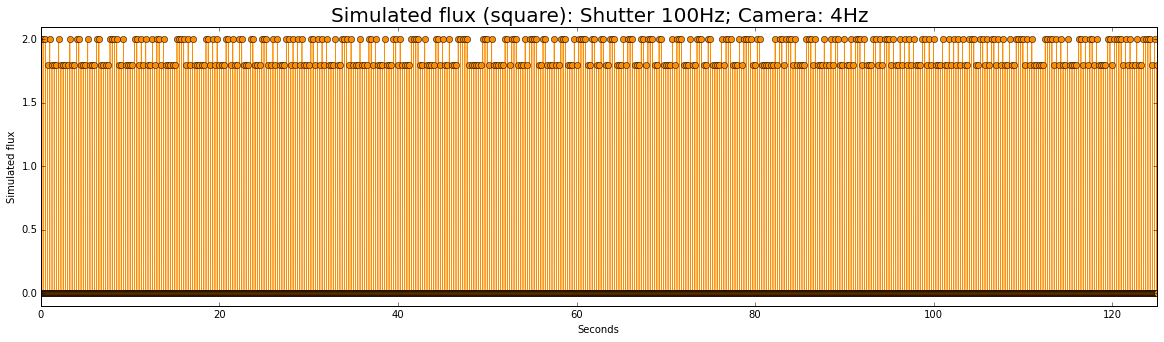

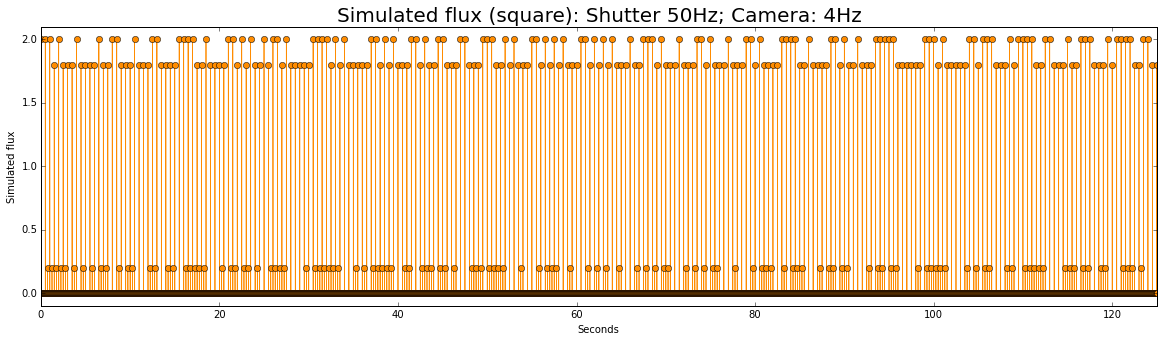

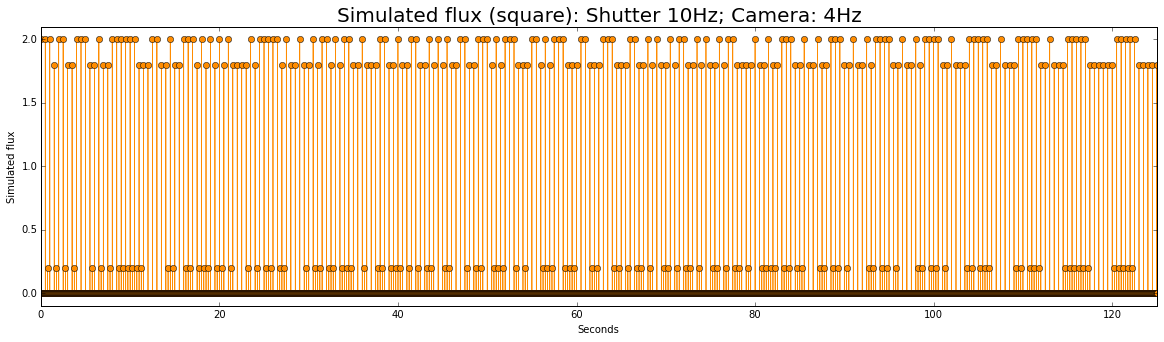

In [19]:
#Plotting the simulated fluxes for camera speed of 4hz
#This flux equals the points in which the camera "meets" the shutter wave
#Stacking the flux over each 10 datapoints and normalizing by 10

inter_sq4 = {}

for i in shutter:
    temp = (square[i])*cam4_05ms

    pl.figure(figsize(20, 5))
    intinter = np.zeros(150000)
    for j in range(10): intinter += temp[j::10]
    inter_sq4[str(i)] = intinter/10
    pl.plot(time2[::10], inter_sq4[str(i)], 
            '-', color='darkorange', linewidth = 0.75)
    pl.plot(time2[::10], inter_sq4[str(i)], 
            'o', color='darkorange', linewidth = 0.75)
    
    pl.title('Simulated flux (square): Shutter '+str(i)+'Hz; Camera: 4Hz', fontsize=20)
    pl.xlabel('Seconds')
    pl.ylabel('Simulated flux')
    pl.xlim(0,125)
    pl.ylim(-.1, 2.1)
    pl.show()

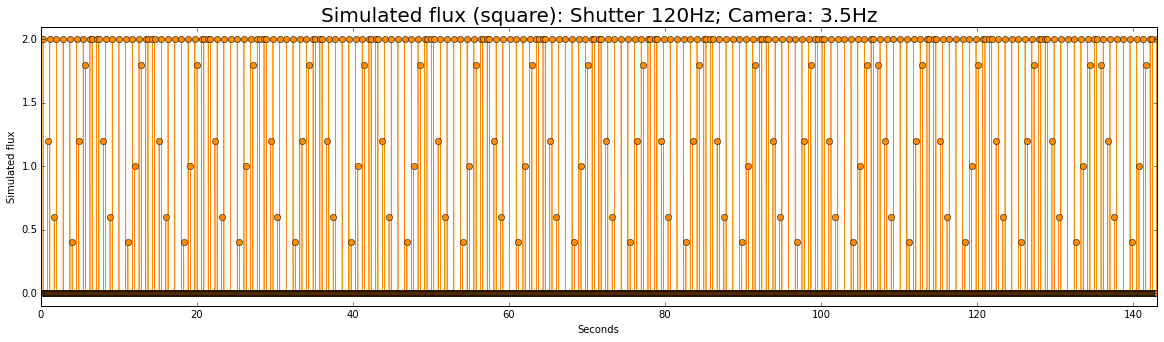

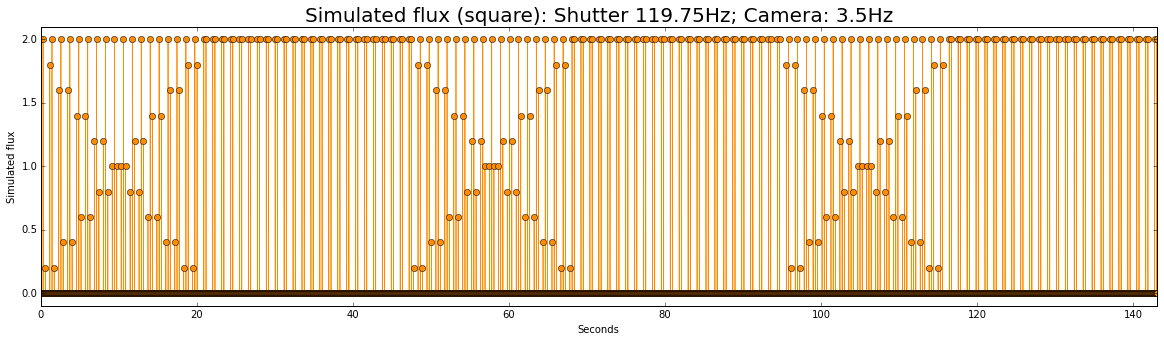

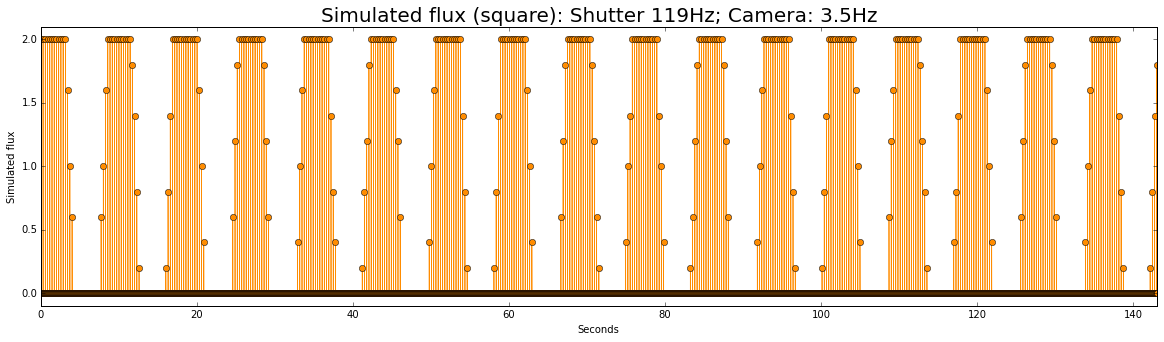

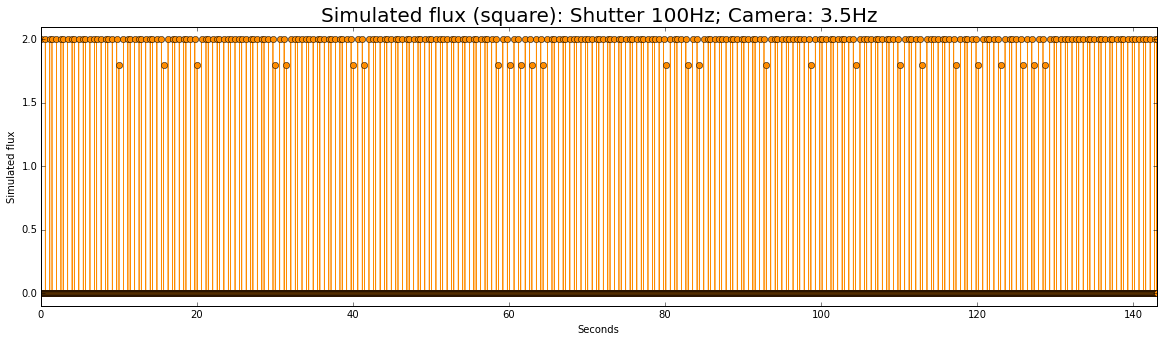

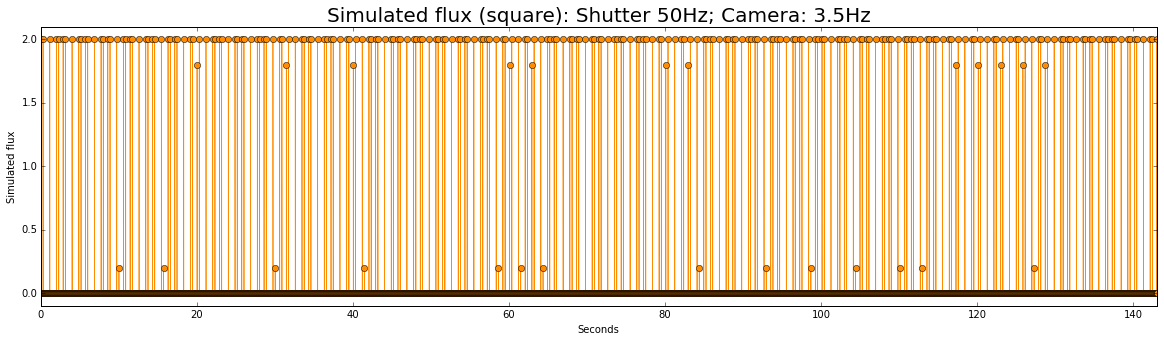

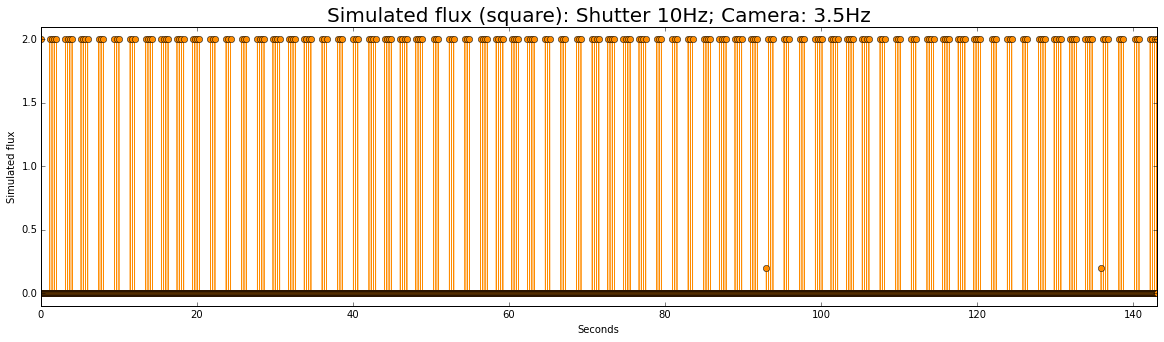

In [20]:
#Plotting the simulated fluxes for camera speed of 3.5hz
#This flux equals the points in which the camera "meets" the shutter wave
#Stacking the flux over each 10 datapoints and normalizing by 10

inter_sq35 = {}

for i in shutter:
    temp = (square[i])*cam35_05ms

    pl.figure(figsize(20, 5))
    intinter = np.zeros(150000)
    for j in range(10): intinter += temp[j::10] 
    inter_sq35[str(i)] = intinter/10
    pl.plot(time2[::10], inter_sq35[str(i)], 
            '-', color='darkorange', linewidth = 0.75)
    pl.plot(time2[::10], inter_sq35[str(i)], 
            'o', color='darkorange', linewidth = 0.75)
    
    pl.title('Simulated flux (square): Shutter '+str(i)+'Hz; Camera: 3.5Hz', fontsize=20)
    pl.xlabel('Seconds')
    pl.ylabel('Simulated flux')
    pl.xlim(0,143)
    pl.ylim(-.1,2.1)
    pl.show()

## Residuals (divided by sine wave)

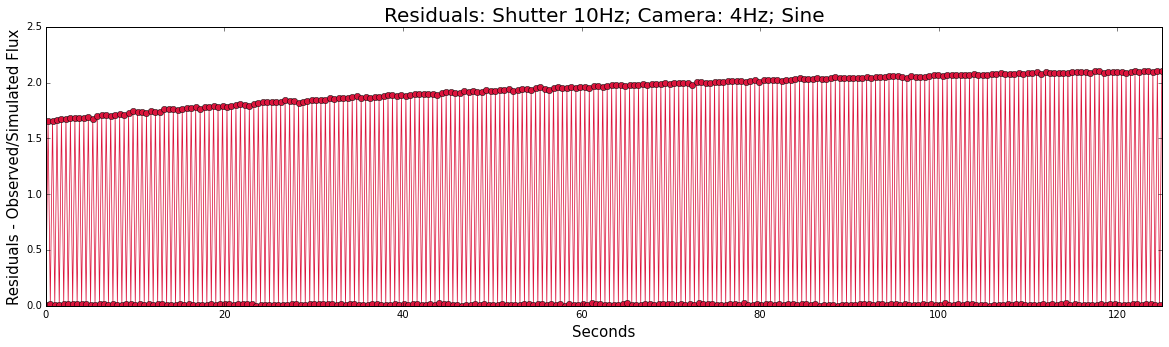

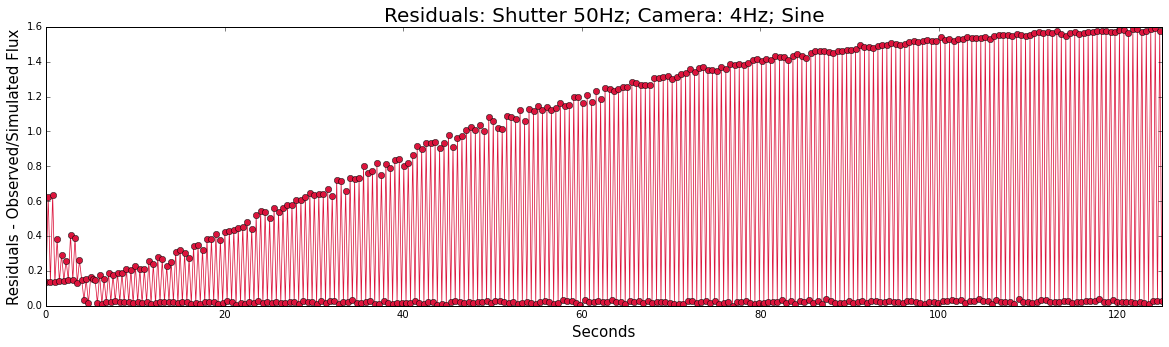

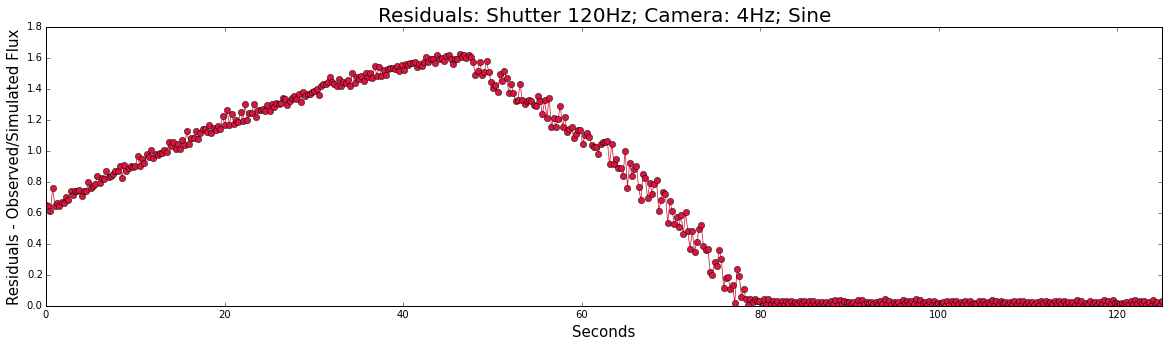

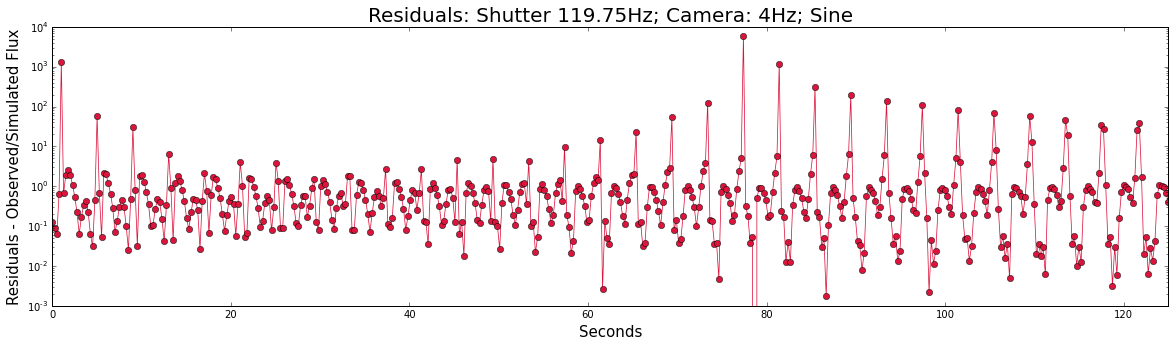

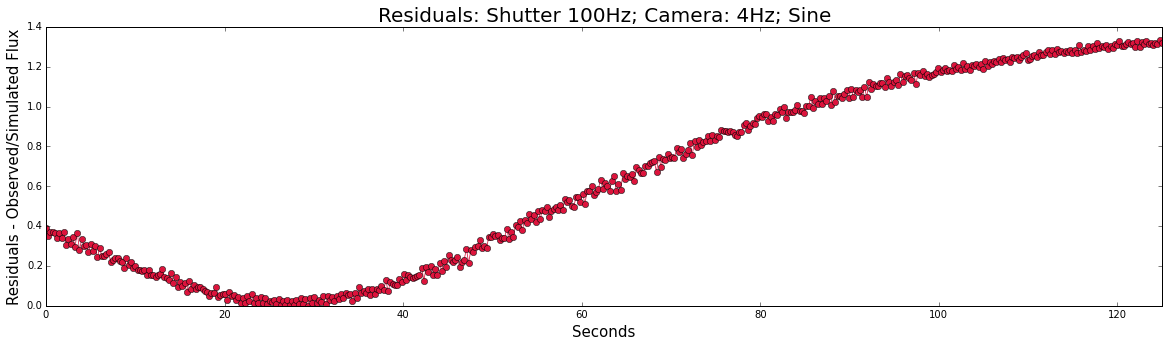

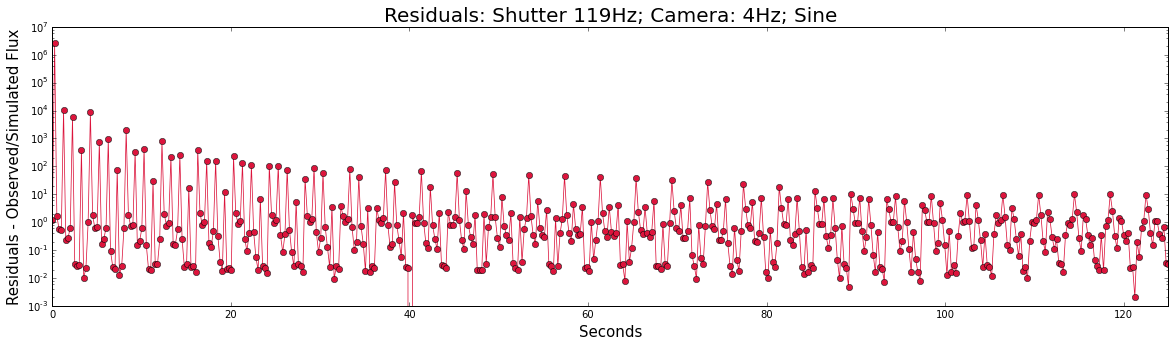

In [21]:
# Divide the observed time series by the simulated sine wave
# 4 Hz

res_sn4 = {}

for key, value in runtime4.iteritems():
    # to be consistent with the 500 points on the flux wave
    # sample the points on the sine wave over each 250ms interval
    inter_sn4[key] = inter_sn4[key][np.arange(125000)]
    res_sn4[key] = flux4[key]/inter_sn4[key][np.arange(125000)%250==0]
    
    pl.figure(figsize=(20,5))
    if np.max(res_sn4[key])>2.2:
        pl.yscale('log')
    else:
        pass
    pl.plot(value, res_sn4[key], '-', color='crimson', linewidth=0.75)
    pl.plot(value, res_sn4[key], 'o', color='crimson')
    pl.xlabel("Seconds", fontsize=15)
    pl.ylabel("Residuals - Observed/Simulated Flux", fontsize=15)
    pl.title('Residuals: Shutter '+key+'Hz; Camera: 4Hz; Sine', fontsize=20)
    pl.xlim(0,125)
    pl.show()

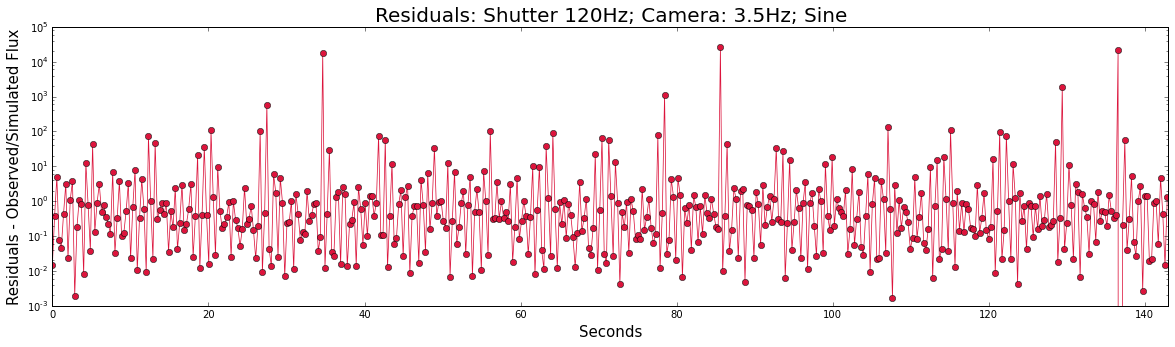

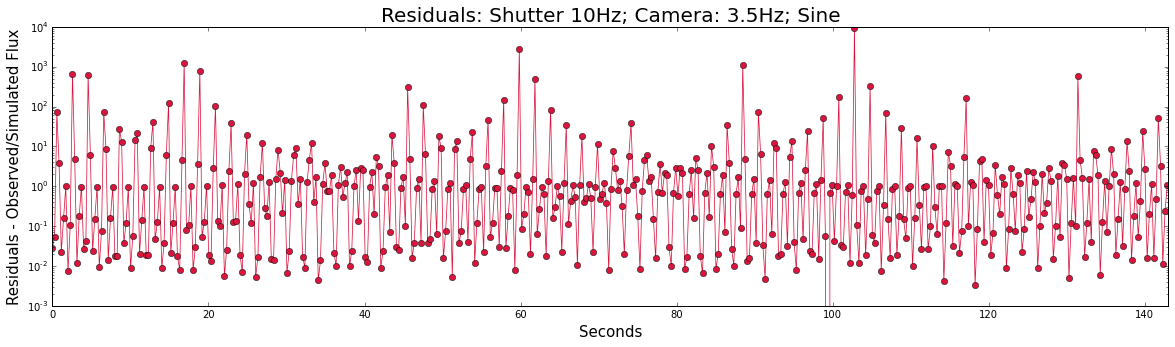

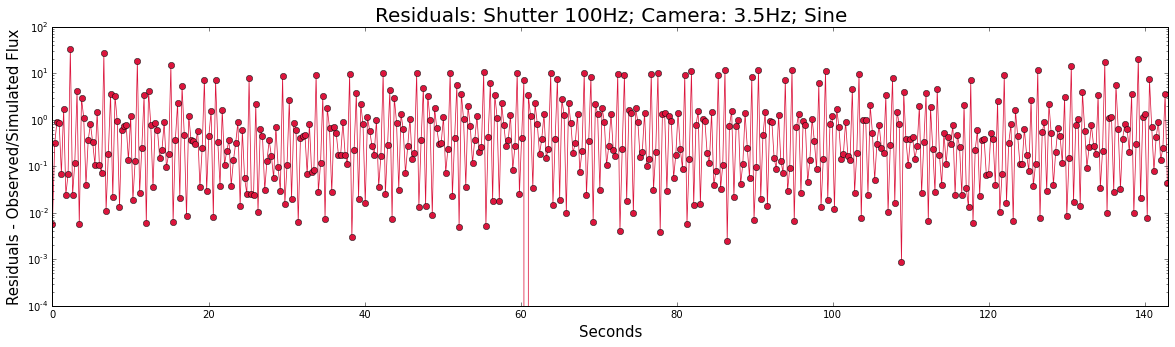

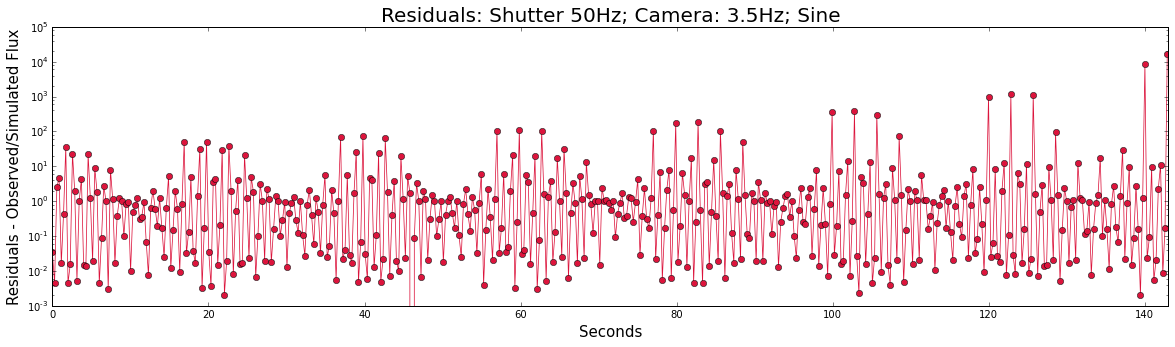

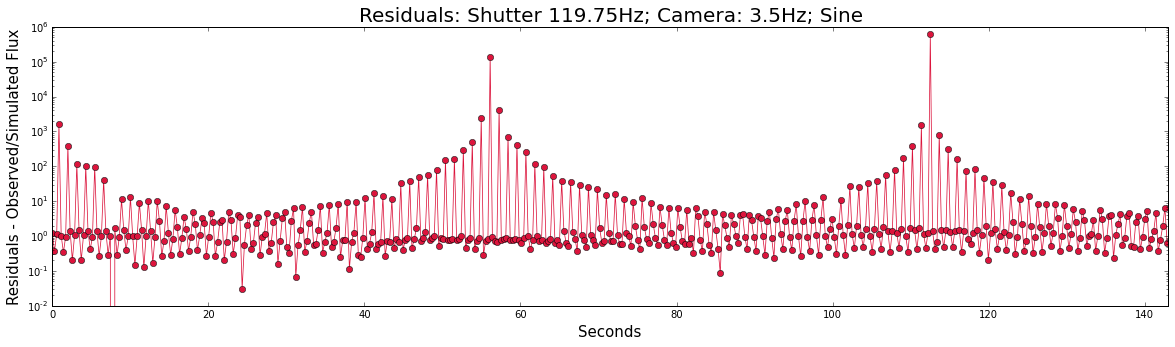

In [22]:
# Divide the observed time series by the simulated sine wave
# 3.5 Hz

res_sn35 = {}

for key, value in runtime35.iteritems():
    # to be consistent with the 500 points on the flux wave
    # sample the points on the sine wave over each 286ms interval
    inter_sn35[key] = inter_sn35[key][np.arange(143000)]
    res_sn35[key] = flux35[key]/inter_sn35[key][np.arange(143000)%286==0]
    
    pl.figure(figsize=(20,5))
    pl.yscale('log')
    pl.plot(value, res_sn35[key], '-', color='crimson', linewidth=0.75)
    pl.plot(value, res_sn35[key], 'o', color='crimson')
    pl.xlabel("Seconds", fontsize=15)
    pl.ylabel("Residuals - Observed/Simulated Flux", fontsize=15)
    pl.title('Residuals: Shutter '+key+'Hz; Camera: 3.5Hz; Sine', fontsize=20)
    xlim(0,143)
    pl.show()

## Residuals (divided by square wave)

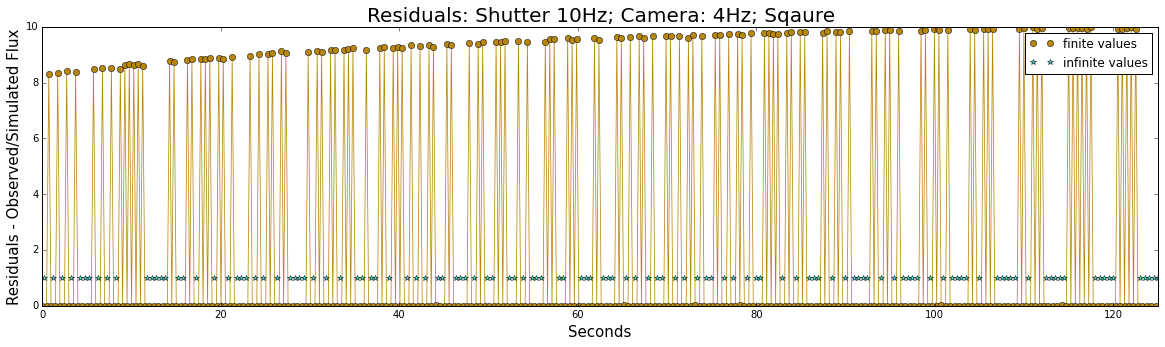

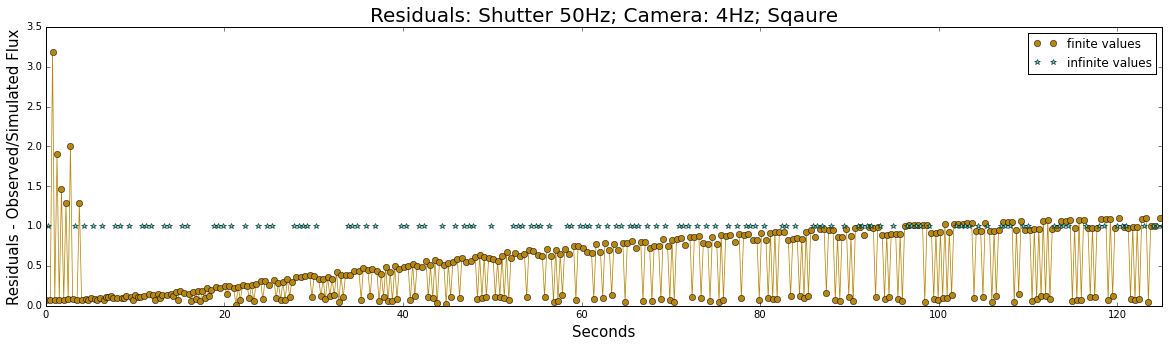

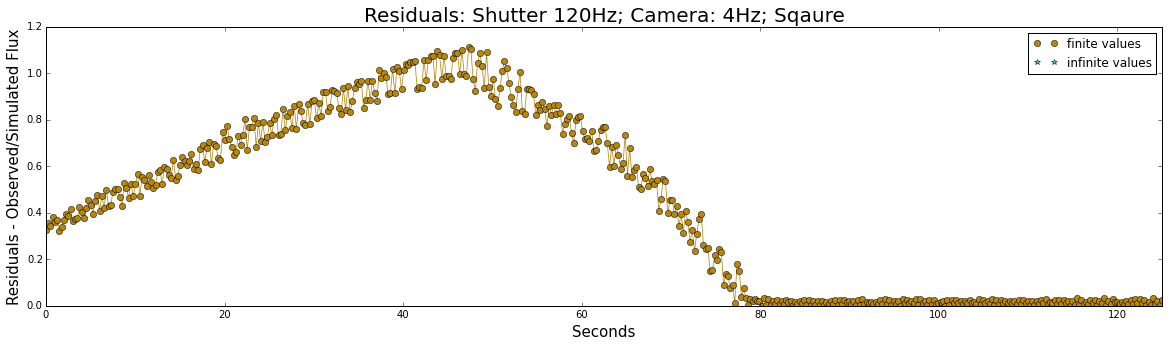

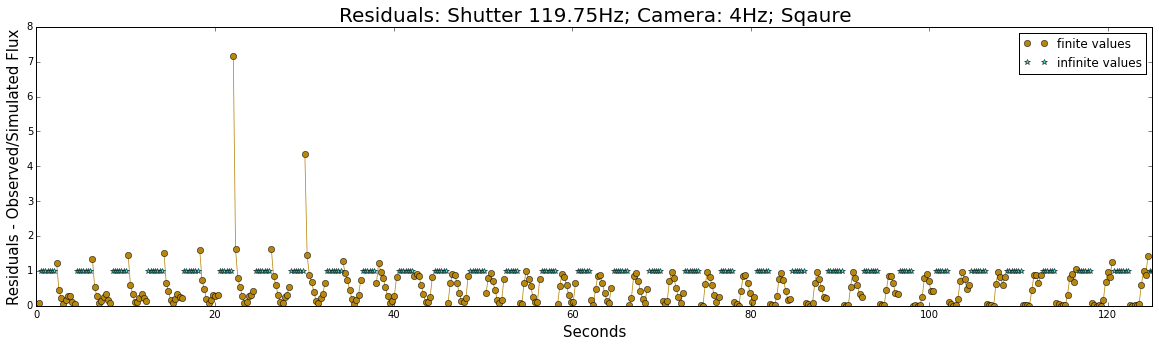

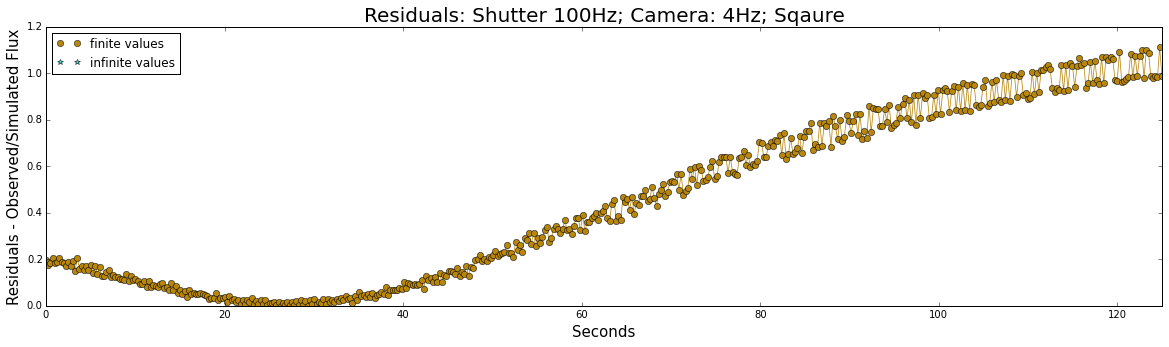

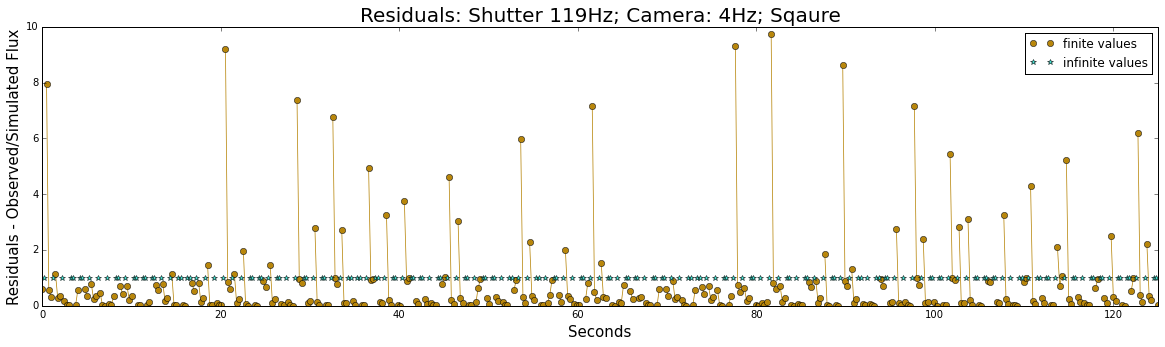

In [23]:
# Divide the observed time series by the simulated square wave
# 4 Hz

res_sq4 = {}

for key, value in runtime4.iteritems():
    # to be consistent with the 500 points on the flux wave
    # sample the points on the square wave over each 250ms interval
    inter_sq4[key] = inter_sq4[key][np.arange(125000)]
    res_sq4[key] = flux4[key]/inter_sq4[key][np.arange(125000)%250==0]
    
    if value.shape != res_sq4[key].shape:
        print "Residuals need to have the same length as runtime!"
        break
    
    pl.figure(figsize=(20,5))
    pl.plot(value, res_sq4[key], '-', color='darkgoldenrod', linewidth=0.75)
    pl.plot(value, res_sq4[key], 'o', color='darkgoldenrod', label='finite values')
    
    inf_idx = np.where(res_sq4[key]==inf)[0]
    pl.plot(value[inf_idx], np.ones(len(inf_idx)), '*', c='turquoise', label='infinite values')
    
    pl.xlabel("Seconds", fontsize=15)
    pl.ylabel("Residuals - Observed/Simulated Flux", fontsize=15)
    pl.title('Residuals: Shutter '+key+'Hz; Camera: 4Hz; Sqaure', fontsize=20)
    pl.legend(loc='best')
    pl.xlim(0,125)
    pl.show()

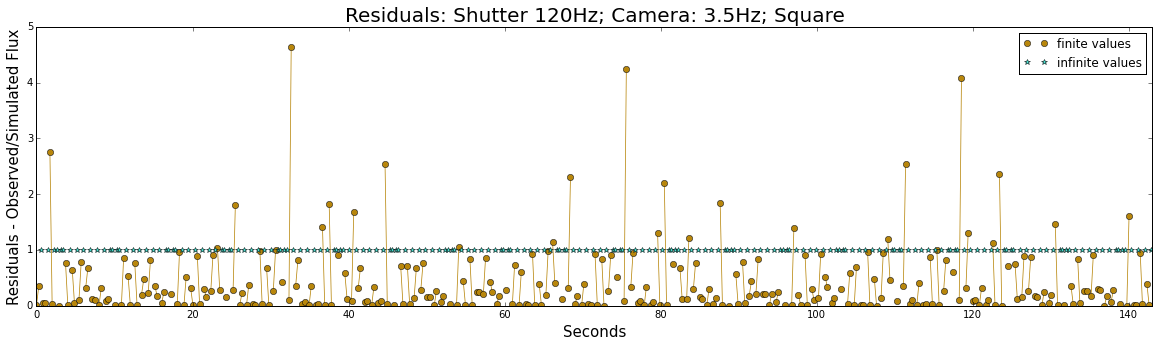

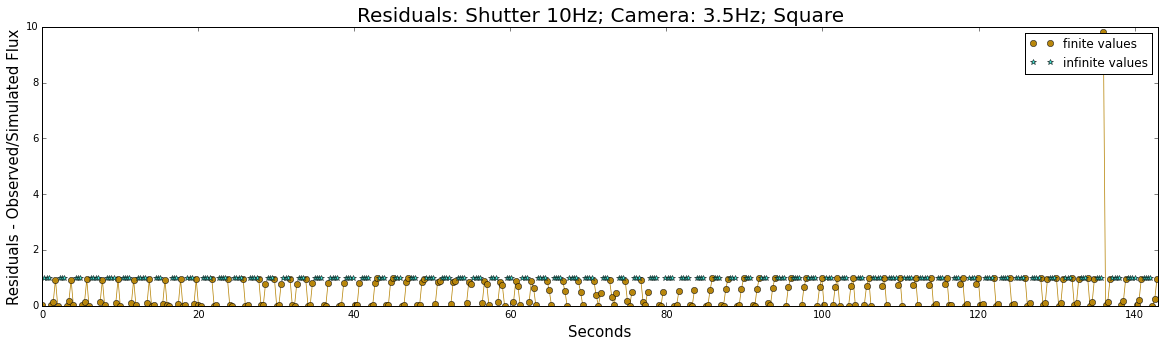

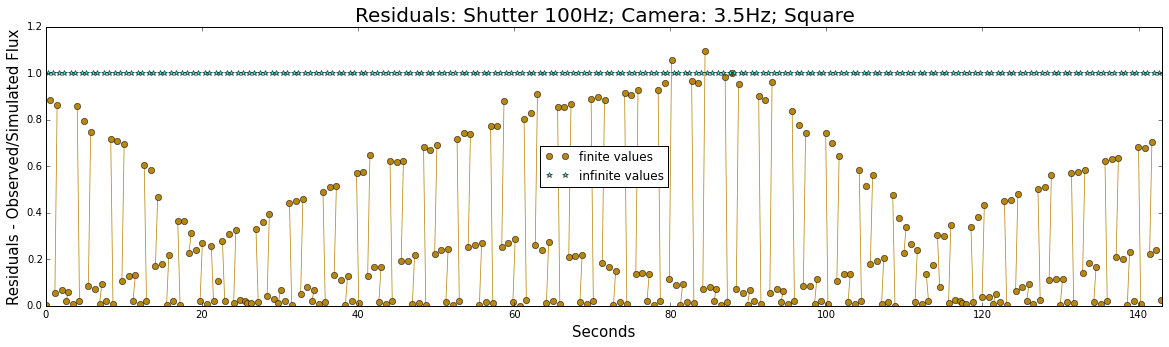

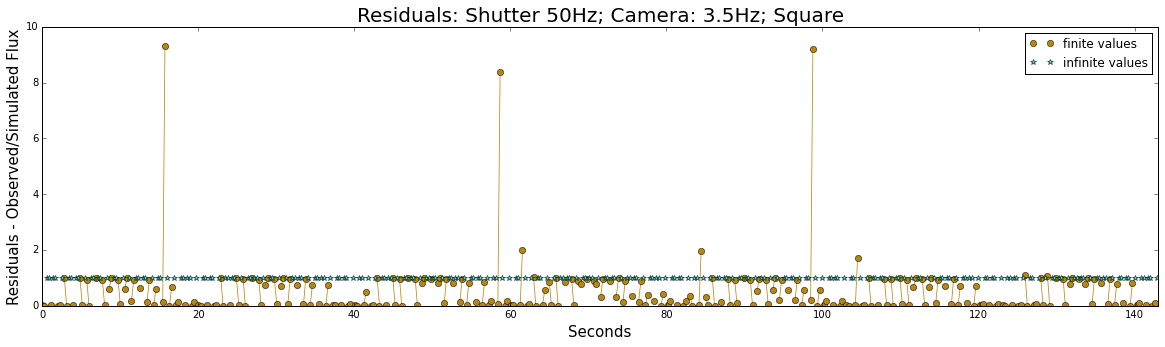

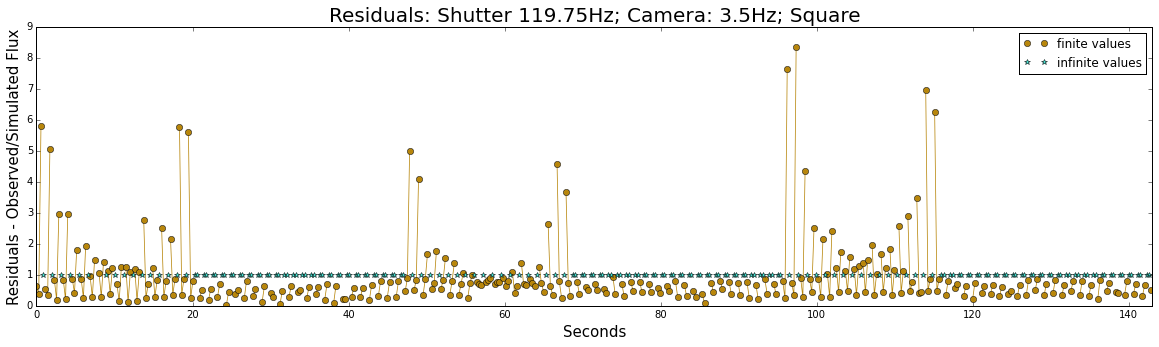

In [24]:
# Divide the observed time series by the simulated square wave
# 3.5 Hz

res_sq35 = {}

for key, value in runtime35.iteritems():
    # to be consistent with the 500 points on the flux wave
    # sample the points on the square wave over each 286ms interval
    if key!='119': # remember we had an issue with this one
        inter_sq35[key] = inter_sq35[key][np.arange(143000)]
        res_sq35[key] = flux35[key]/inter_sq35[key][np.arange(143000)%286==0]

        if value.shape != res_sq35[key].shape:
            print "Residuals need to have the same length as runtime!"
            break
            
        pl.figure(figsize=(20,5))
        pl.plot(value, res_sq35[key], '-', color='darkgoldenrod', linewidth=0.75)
        pl.plot(value, res_sq35[key], 'o', color='darkgoldenrod', label='finite values')
        
        inf_idx = np.where(res_sq35[key]==inf)[0]
        pl.plot(value[inf_idx], np.ones(len(inf_idx)), '*', c='turquoise', label='infinite values')
    
        pl.xlabel("Seconds", fontsize=15)
        pl.ylabel("Residuals - Observed/Simulated Flux", fontsize=15)
        pl.title('Residuals: Shutter '+key+'Hz; Camera: 3.5Hz; Square', fontsize=20)
        pl.xlim(0,143)
        pl.legend(loc='best')
        pl.show()
    else:
        pass

### It is clear that the gaps in the wave are caused by the infinite results in the divisions

## Folding the flux time series to 2 shutter cycles

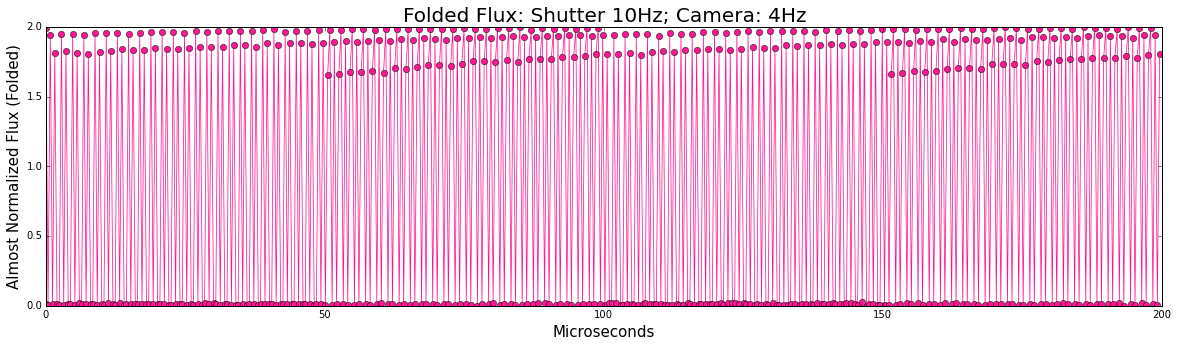

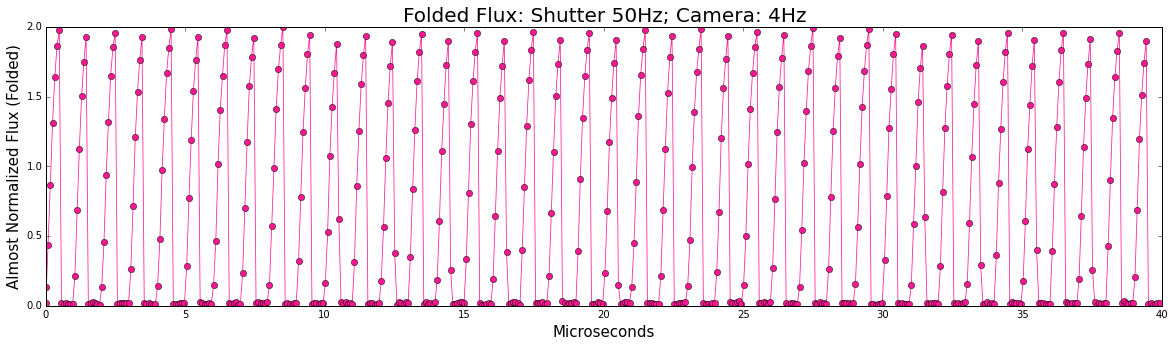

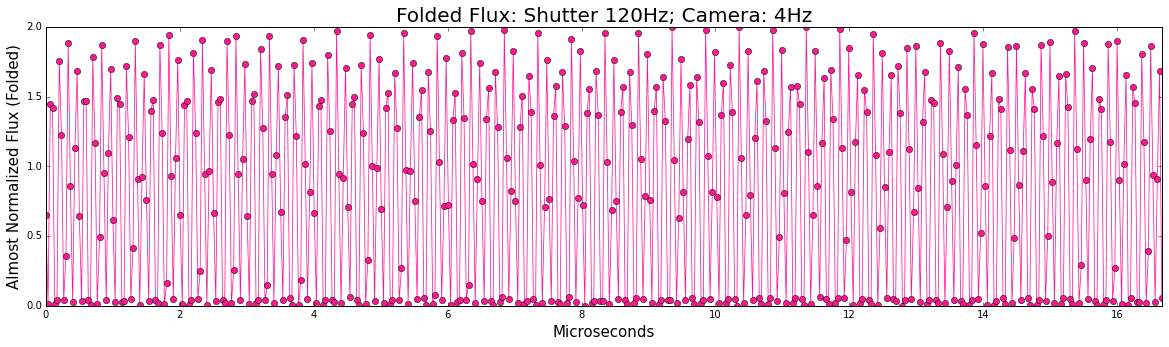

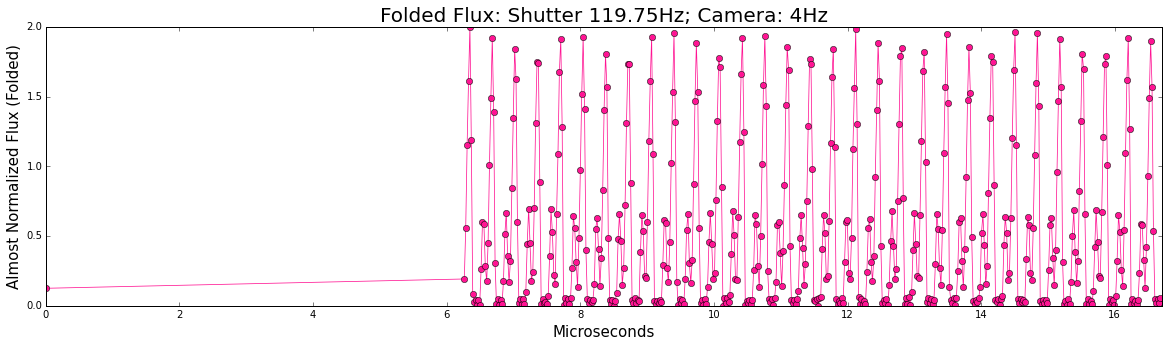

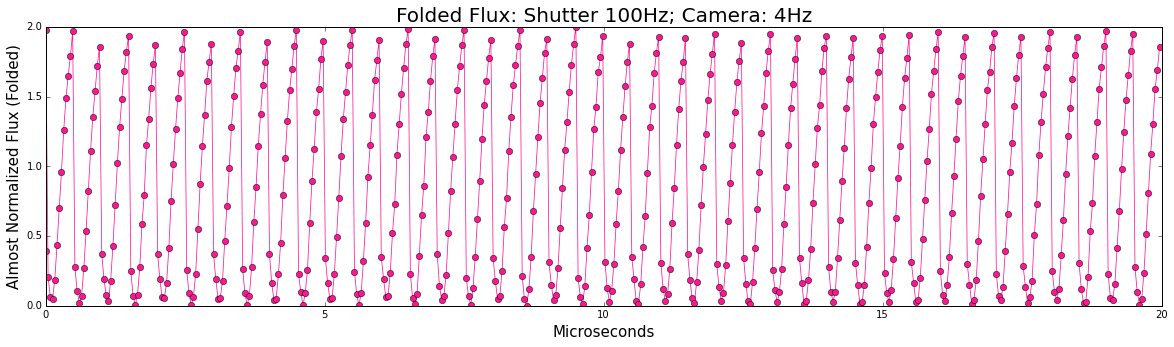

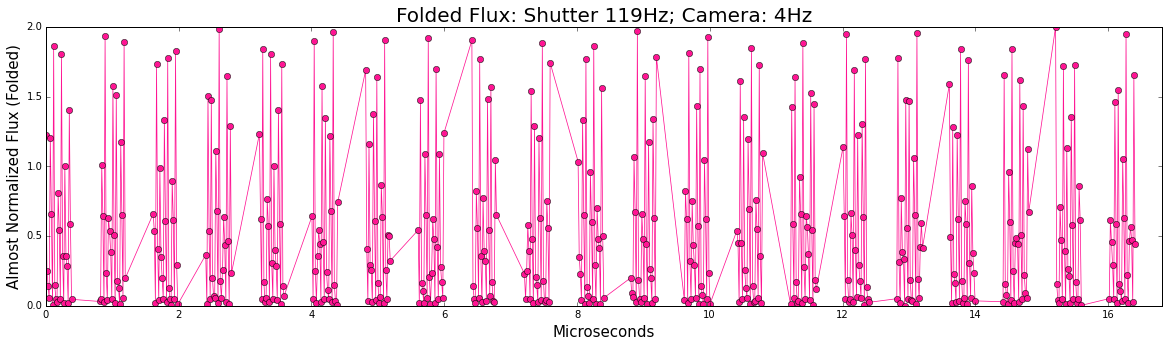

In [25]:
# 4Hz
# The original runtime is by seconds, so we need to multiply by 1000 before modding by 2 shuttercycles

folded_4 = {}

for key, value in flux4.iteritems():
    folded_4[key] = {}
    runtime_mod4 = (1000*runtime4[key])%(2*1/float(key)*1000) 
    sorted_idx4 = np.asarray([i[0] for i in sorted(enumerate(runtime_mod4), key=lambda x:x[1])])
    folded_4[key]['time'] = runtime_mod4[sorted_idx4]
    folded_4[key]['flux'] = value[sorted_idx4]
    
    pl.figure(figsize=(20,5))
    pl.plot(folded_4[key]['time'], folded_4[key]['flux'], '-', color='deeppink', linewidth=0.75)
    pl.plot(folded_4[key]['time'], folded_4[key]['flux'], 'o', color='deeppink')
    pl.xlabel("Microseconds", fontsize=15)
    pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
    pl.title('Folded Flux: Shutter '+key+'Hz; Camera: 4Hz', fontsize=20)
    xlim(0,2*1/float(key)*1000)
    pl.show()

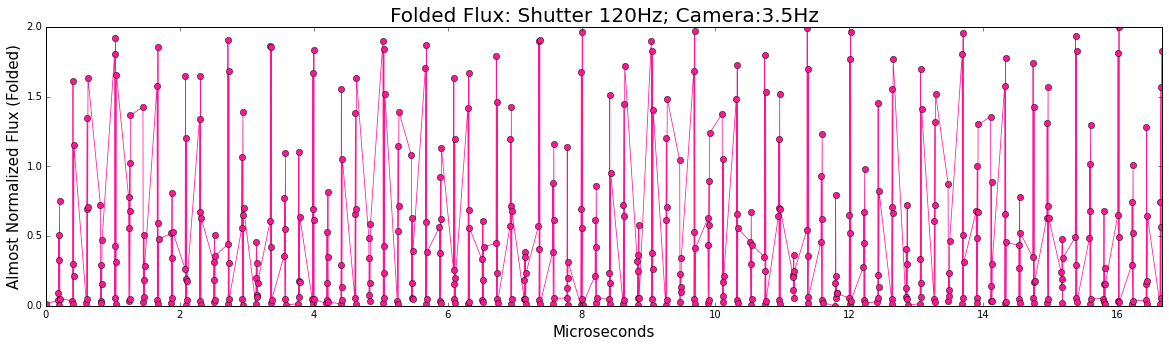

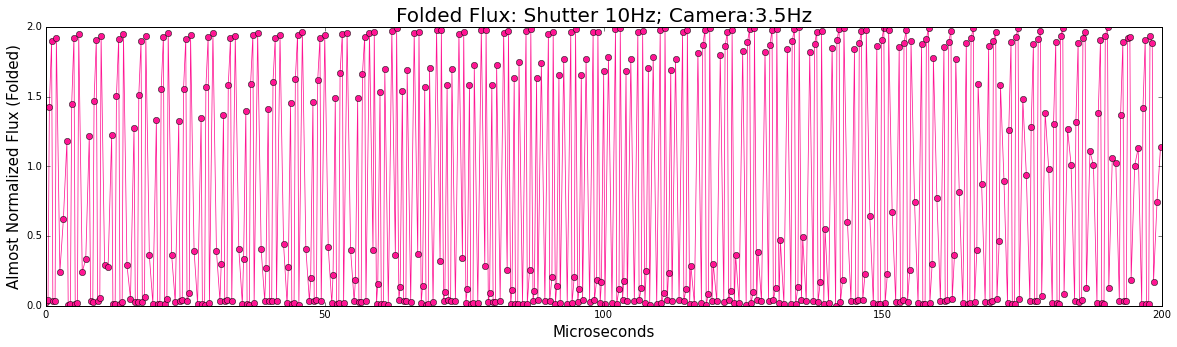

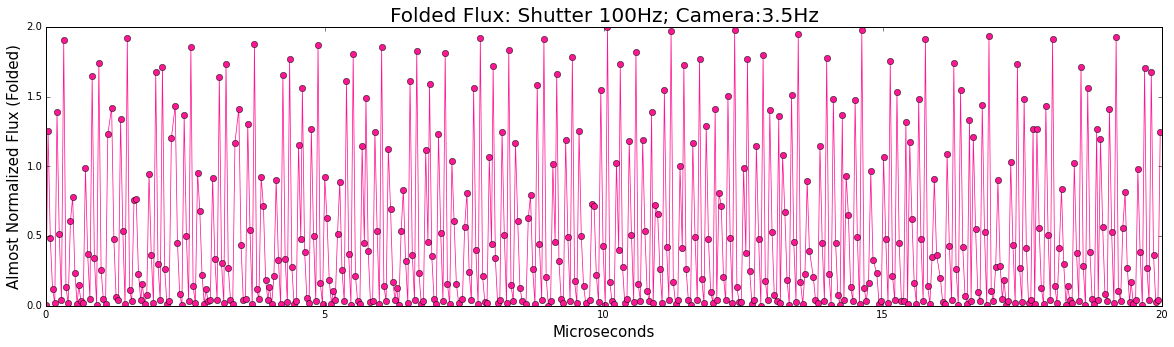

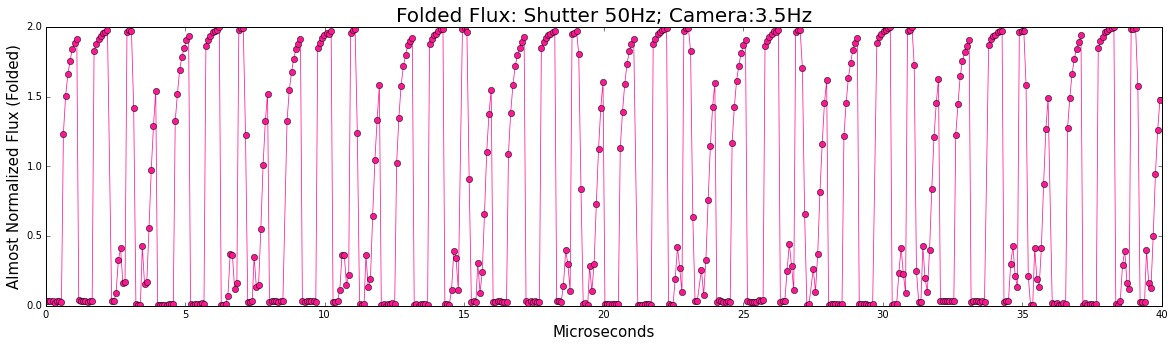

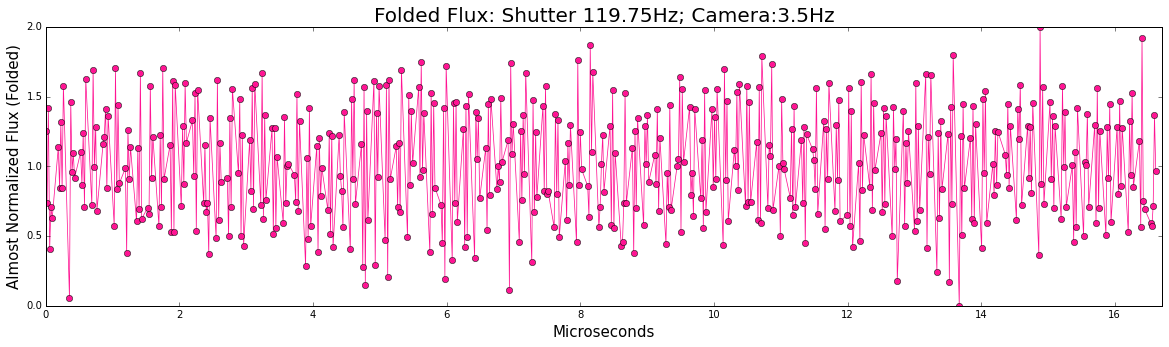

In [26]:
# 3.5Hz

folded_35 = {}

for key, value in flux35.iteritems():
    folded_35[key] = {}
    runtime_mod35 = (1000*runtime35[key])%(2*1/float(key)*1000)
    sorted_idx35 = np.asarray([i[0] for i in sorted(enumerate(runtime_mod35), key=lambda x:x[1])])
    folded_35[key]['time'] = runtime_mod35[sorted_idx35]
    folded_35[key]['flux'] = value[sorted_idx35]
    
    pl.figure(figsize=(20,5))
    pl.plot(folded_35[key]['time'], folded_35[key]['flux'], '-', color='deeppink', linewidth=0.75)
    pl.plot(folded_35[key]['time'], folded_35[key]['flux'], 'o', color='deeppink')
    pl.xlabel("Microseconds", fontsize=15)
    pl.ylabel("Almost Normalized Flux (Folded)", fontsize=15)
    pl.title('Folded Flux: Shutter '+key+'Hz; Camera:3.5Hz', fontsize=20)
    xlim(0, 2*1/float(key)*1000)
    pl.show()